### Model and Results

In [1]:
# LIBS

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks, models, optimizers
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
# import statsmodels.api as sm
# from pmdarima import auto_arima
#bibliotecas usadas no gridserach
from sklearn.model_selection import TimeSeriesSplit
import keras
#salvar arquivo de treinamento
from tensorflow.keras.models import load_model


register_matplotlib_converters()
sns.set_style("darkgrid")

plt.rc("figure", figsize=(16, 6))
plt.rc("font", size=13)

from matplotlib.pyplot import figure

figure(figsize = (16, 6), dpi = 100)

<Figure size 1600x600 with 0 Axes>

<Figure size 1600x600 with 0 Axes>

In [2]:
#gridsearch
def grid_search_cv(modelo, units, X_train, learning_rates, y_train, epochs_list, batch_sizes, patiences, model_name):
    best_loss = float('inf')
    best_params = {}
    for lr in learning_rates:
        for epochs in epochs_list:
            for batch_size in batch_sizes:
                for patience in patiences:
                    model = modelo(units, X_train, lr)
                    histories = fit_model_with_cross_validation(model, X_train, y_train, model_name, patience, epochs, batch_size)
                    mean_history = calculate_mean_history(histories)
                    val_loss = min(mean_history['val_loss'])
                    print("Val Loss: ", val_loss, "learning rate: ", lr, "epochs: ",  epochs, "batch_size: " , batch_size, "patience: ", patience)
                    if val_loss < best_loss:
                        best_loss = val_loss
                        best_params = {'learning_rate': lr, 'epochs': epochs, 'batch_size': batch_size, 'patience': patience} 
    print('O modelo '+model_name+ ' tem como melhores parametros os seguintes: learning_rate '+ str(best_params['learning_rate'])+' epochs: '+ str(best_params['epochs'])+' batch_size: '+ str(best_params['batch_size'])+ ' patience: '+ str(best_params['patience']))
    return best_params

#validação cruzada
def fit_model_with_cross_validation(model, xtrain, ytrain, model_name, patience, epochs, batch_size):
    tscv = TimeSeriesSplit(n_splits=4)
    fold = 1
    histories = []
    for train_index, val_index in tscv.split(xtrain):
        x_train_fold, x_val_fold = xtrain[train_index], xtrain[val_index]
        y_train_fold, y_val_fold = ytrain[train_index], ytrain[val_index]
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, min_delta=1e-5)
        history = model.fit(x_train_fold, y_train_fold, epochs=epochs, validation_data=(x_val_fold, y_val_fold), batch_size=batch_size, callbacks=[early_stop], verbose=1)
        print('\n\nTREINAMENTO - Fold', fold, 'do modelo:', model_name)
        histories.append(history)
        fold += 1   
    return histories 

# calcula a media das metricas obtidas nos historys - validação cruzada
def calculate_mean_history(histories):
    mean_history = {'loss': [], 'root_mean_squared_error': [], 'val_loss': [], 'val_root_mean_squared_error': []}
    for fold_history in histories:
        for key in mean_history.keys():
            mean_history[key].append(fold_history.history[key])
    for key, values in mean_history.items():
        max_len = max(len(val) for val in values)
        for i in range(len(values)):
            if len(values[i]) < max_len: #caso em que nao se treina todas as epocas (patience)
                values[i] += [values[i][-1]] * (max_len - len(values[i])) #completa o restante da lista com o ultimo valor obtido
    for key, values in mean_history.items():
        mean_history[key] = [sum(vals) / len(vals) for vals in zip(*values)]
    
    return mean_history

#função para salvar o modelo
def save_model(model, directory, substring_desejada, modelo):
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_path = os.path.join(directory, f'{substring_desejada +modelo} - final_model.keras')
    model.save(file_path)
    print(f"Modelo salvo como '{file_path}'")

#plotar os graficos da media dos treinamentos por epocas: validação cruzada
def plot_loss_cv(mean_history, model_name, link):
    epochs = range(1, len(mean_history['loss']) + 1)
    plt.plot(epochs, mean_history['loss'], label='Train Loss')
    plt.plot(epochs, mean_history['val_loss'], label='Validation Loss')
    plt.title('Mean Training and Validation Loss for '+' '+link + ' '+ model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_rmse_cv(mean_history):
    epochs = range(1, len(mean_history['root_mean_squared_error']) + 1)
    plt.plot(epochs, mean_history['root_mean_squared_error'], label='Train RMSE')
    plt.plot(epochs, mean_history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.title('Mean Training and Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()


In [3]:
# Main functions

# Create input dataset
# The input shape should be [samples, time steps, features
def create_dataset (X, look_back = 3):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)

# Create GRU model
def create_gru(units, train, learning_rate): 
    model = Sequential() 
    # Old Config
    model.add(GRU(units = units, return_sequences = True, input_shape = [train.shape[1], train.shape[2]]))
    model.add(GRU(units = units))   
    # model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])
    return model

# Create LSTM model
def create_lstm(units, train, learning_rate): 
    model = Sequential() 
    # Old Config
    model.add(LSTM(units = units, return_sequences = True, input_shape = [train.shape[1], train.shape[2]]))
    model.add(LSTM(units = units)) 
    # model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])
    
    return model

#treinamento do modelo
def fit_model(model, xtrain, ytrain, model_name, patience, epochs, batch_size ):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience, restore_best_weights=True)
    history = model.fit(xtrain, ytrain, epochs = epochs, validation_split = 0.2, batch_size = batch_size, shuffle = True, callbacks=[early_stop]) 
    print('\n\nTREINAMENTO: ' + model_name)
    return history

########################################### plote dos graficos de treinamento ###################################################################################
 #Plot train loss and validation loss
def plot_loss(history, model_name, link):
     plt.figure(figsize = (15, 6), dpi=100)
     plt.plot(history.history['loss'])
     plt.plot(history.history['val_loss'])
     plt.title('Model Train vs Validation Loss for '+' '+link + ' '+ model_name)
     plt.ylabel('Loss')
     plt.xlabel('Epoch')
     plt.legend(['Train loss', 'Validation loss'], loc='upper right')
def plot_rmse(history, model_name, link):
     plt.figure(figsize = (15, 6), dpi=100)
     plt.plot(history.history['rmse'])
     plt.plot(history.history['val_rmse'])
     plt.title('Model Train vs RMSE for '+' '+link + ' '+ model_name)
     plt.ylabel('rmse')
     plt.xlabel('Epoch')
     plt.legend(['Train rmse', 'Validation loss'], loc='upper right')
################################################################################################################################################################
# Make prediction
def prediction(model, xtest, ytest, myscaler, model_name, link): 
    prediction = model.predict(xtest) 
    prediction = myscaler.inverse_transform(prediction) 
    # dataframe_prediction = pd.DataFrame(data={'Predições':prediction.flatten()})
    dataframe_prediction = pd.DataFrame(data={'Prediction':prediction.flatten(), 'Test':ytest.flatten()})
    dataframe_prediction.to_csv('../../results/forecasting-values '+model_name+' '+link+'')
    return prediction

# Plot test data vs prediction
# def plot_future(predictionGRU, predictionLSTM, y_test, link):
#     plt.figure(figsize=(15, 6), dpi=100)
#     range_future = len(y_test)
#     plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
#     plt.plot(np.arange(range_future), np.array(predictionGRU), label='GRU')
#     plt.plot(np.arange(range_future), np.array(predictionLSTM), label='LSTM')
#     # dict_to_dataframe_prediction = {
#     #     # "range_future": np.arange(range_future),
#     #     f"prediction{model_name}": np.array(prediction.squeeze())
#     # }
    
#     plt.title('Test data vs prediction for '+ link)
#     plt.legend(loc='upper left')
#     plt.xlabel('Time')
#     plt.ylabel('Mbis/s')

#     #Tenta salvar a fig
#     save_path = '../../graficos/predicoes/round_2/graficos/' + link + '.png'
#     try:
#         plt.savefig(save_path)
#         print(f"A figura foi salva com sucesso em: {save_path}")
#     except Exception as e:
#         print(f"Erro ao salvar a figura: {e}")

#     plt.show()

def plot_future(predictionGRU, predictionLSTM, y_test, link):
    plt.figure(figsize=(15, 6), dpi=100)
    range_future = len(y_test)
    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(predictionGRU), label='GRU')
    plt.plot(np.arange(range_future), np.array(predictionLSTM), label='LSTM')
    # dict_to_dataframe_prediction = {
    #     # "range_future": np.arange(range_future),
    #     f"prediction{model_name}": np.array(prediction.squeeze())
    # }
    
    plt.title('Test data vs prediction for '+ link)
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Mbis/s')

    #Tenta salvar a fig
    save_path = '../../results/plots/forecasting/' + link + '.png'
    try:
        plt.savefig(save_path)
        print(f"A figura foi salva com sucesso em: {save_path}")
    except Exception as e:
        print(f"Erro ao salvar a figura: {e}")

    plt.show()
    
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    nrmse = rmse/ ((np.max(actual))-(np.min(actual)))
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Normalized Root Mean Square Error: {:.4f}%'.format(nrmse*100))
    print('')

    return rmse, mae, nrmse, model_name

def bits_para_megabits(df, col_vaz):
    # Dados em MegaBits/s e fill
    df[col_vaz] = df[col_vaz]/1000000
    df[col_vaz] = df[col_vaz].replace(-1, df[col_vaz].mean())
    df[col_vaz] = df[col_vaz].fillna(df[col_vaz].mean())

    return df
                
def visualizacao_series(df, col_vazao, titulo):
    df[col_vazao].plot(figsize=(18,6))
    plt.title(titulo)
    plt.ylabel('Vazao (Mbits/s)')
    plt.legend() 
    plt.show()
#calcular media dia repetido
def calcular_media_dia(dataframe, col_data, col_vazao):
    # Ordena o DataFrame pelo campo 'Data'
    dataframe = dataframe.sort_values(by=[col_data])
    
    # Inicializa variáveis para rastrear o dia atual e os valores para calcular a média
    dia_atual = None
    valores_para_media = []
    
    # Função para calcular a média e substituir os valores '-1'
    def calcular_media_e_substituir():
        if len(valores_para_media) > 0:
            media = np.mean(valores_para_media)
            for idx in indices_para_substituir:
                dataframe.at[idx, col_vazao] = media
    
    indices_para_substituir = []
    
    # Itera pelas linhas do DataFrame
    for idx, row in dataframe.iterrows():
        data = row[col_data]
        vazao = row[col_vazao]
        
        if dia_atual is None:
            dia_atual = data
            valores_para_media = []
            indices_para_substituir = []
        
        # Verifica se o valor de 'Vazao' é diferente de '-1'
        if vazao != -1:
            valores_para_media.append(vazao)
        else:
            indices_para_substituir.append(idx)
        
        # Verifica se o dia mudou
        if data != dia_atual:
            calcular_media_e_substituir()
            dia_atual = data
            valores_para_media = []
            indices_para_substituir = []
    
    # Calcula a média e substitui os valores para o último dia
    calcular_media_e_substituir()
    
    return dataframe

# def plot_arima(pred, test, col_test, col_arima):

#     plt.plot(test[col_test], label= 'Real')
#     plt.plot(pred[col_arima], label='ARIMA')
#     plt.legend()
#     plt.xlabel('Tempo')
#     plt.ylabel('Vazão (bits/s)')
#     plt.title('Predição ARIMA')

# def create_arima(ts, col_vazao):

#     tamanho = int(len(ts.index) * 0.8)

#     # Split train data and test data
#     train_size = tamanho

#     # train_data = df.WC.loc[:train_size] -----> it gives a series
#     # Do not forget use iloc to select a number of rows
#     train_data = ts[:train_size]
#     test_data = ts[train_size:]

#     modelo_arima = auto_arima(train_data[col_vazao], seasonal=True, stepwise=True)

#     p, d, q = modelo_arima.order

#     modelo_manual = sm.tsa.ARIMA(train_data[col_vazao], order=(p, d, q)).fit()

#     previsoes = modelo_manual.predict(start=1, end=142, dynamic=False)

#     # Ajustar indice
#     test_data = test_data.reset_index(drop=True)
#     previsoes = pd.DataFrame(previsoes.reset_index(drop=True))

#    return previsoes, test_data

#Funções que ainda não estão acabada e não estão sendo utilizadas #############################################################################################
# def create_cnn(units, train):

#     model = Sequential()

#     model.add(Conv1D(units = units, kernel_sieze = 2, return_sequences=True, input_shape = [train.shape[1], train.shape[2]]))

#     model.add(Flatten())

#     model.add(Conv1D(units = units))

#     model.add(Dense(1))

#     model.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])

#     return model

In [4]:
#TCN
def build_tcn(units, train, learning_rate):
    model = models.Sequential()
    model.add(layers.Conv1D(units, 3, activation='relu', padding='causal', dilation_rate=1, input_shape=[train.shape[1], train.shape[2]]))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv1D(units, 3, activation='relu', padding='causal', dilation_rate=2))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(units, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1)) 
    #optimizer = optimizers.Adam(learning_rate=learning_rate)
    #model.compile(optimizer=optimizer, loss='mse')  # Para regressão. Para classificação, use 'categorical_crossentropy'.
    model.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate=learning_rate), metrics = [RootMeanSquaredError()])
    return model



In [5]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def build_transformer(units, x_train, learning_rate):
    input_shape = x_train.shape[1:]
    inputs = layers.Input(shape=input_shape)

    # Transformer Encoder
    x = layers.MultiHeadAttention(num_heads=4, key_dim=units)(inputs, inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dense(units, activation='relu')(x)

    # Global Pooling and Output
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(units, activation='relu')(x)
    x = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
    return model

def build_nbeats(units, x_train, learning_rate):
    input_shape = x_train.shape[1:]
    inputs = layers.Input(shape=input_shape)

    # N-BEATS block
    x = layers.Dense(units, activation='relu')(inputs)
    x = layers.Dense(units, activation='relu')(x)
    x = layers.Dense(units, activation='relu')(x)
    x = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
    return model

def build_deepar(units, x_train, learning_rate):
    input_shape = x_train.shape[1:]
    model = models.Sequential()
    model.add(layers.LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(layers.LSTM(units))
    model.add(layers.Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
    return model

#def build_cnn_lstm(units, x_train, learning_rate):
def build_tcn(units, x_train, learning_rate):
    input_shape = x_train.shape[1:]
    model = models.Sequential()
    model.add(layers.Conv1D(filters=units, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.LSTM(units))
    model.add(layers.Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
    return model



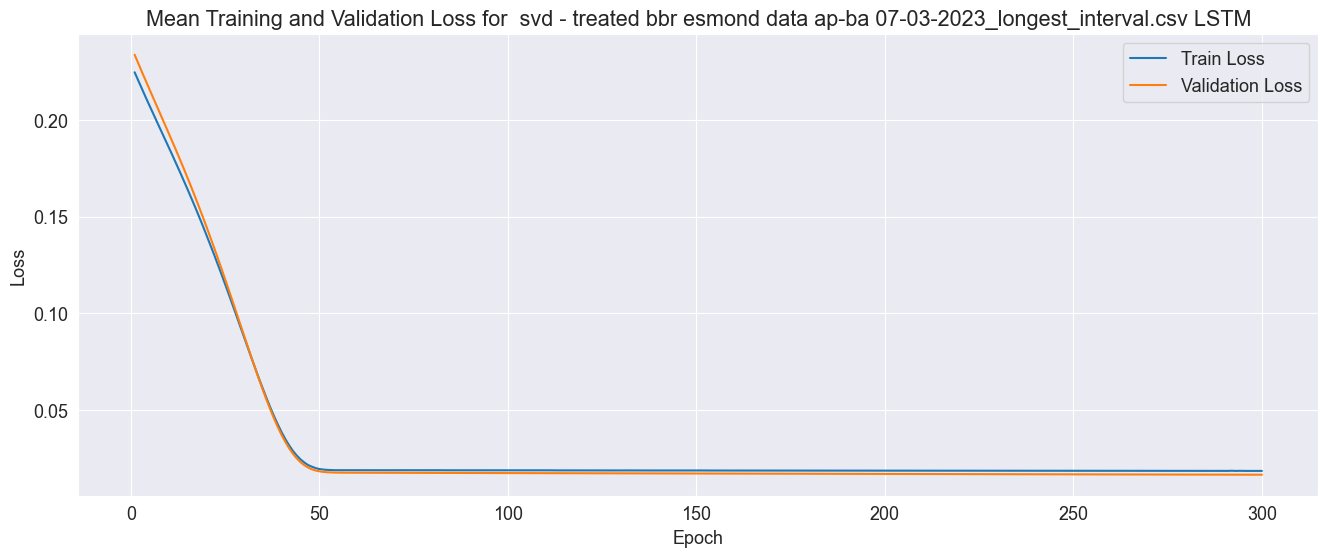

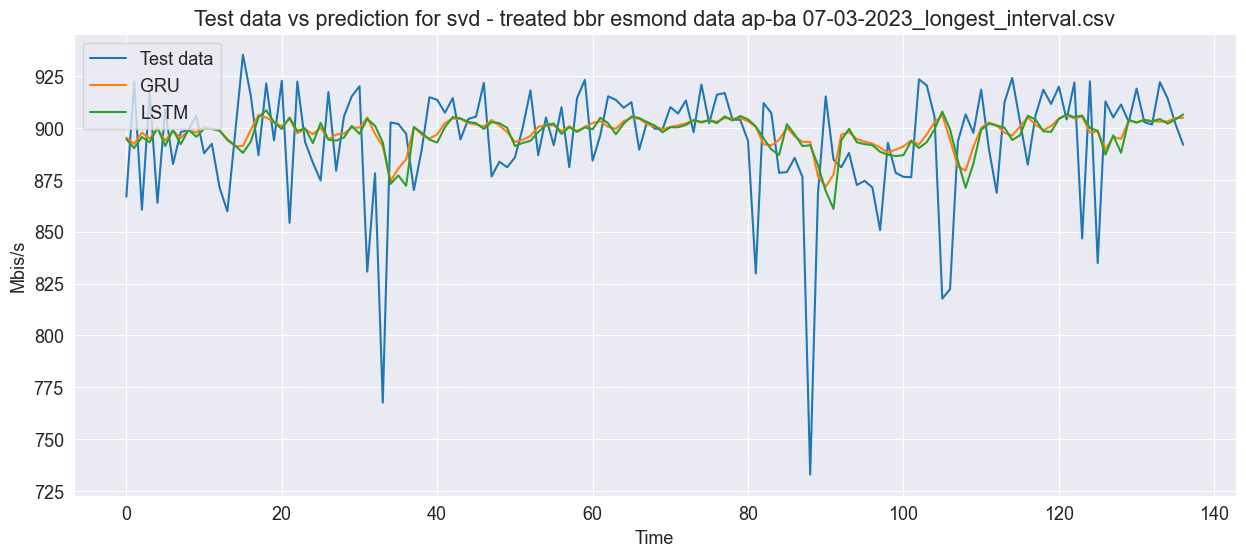

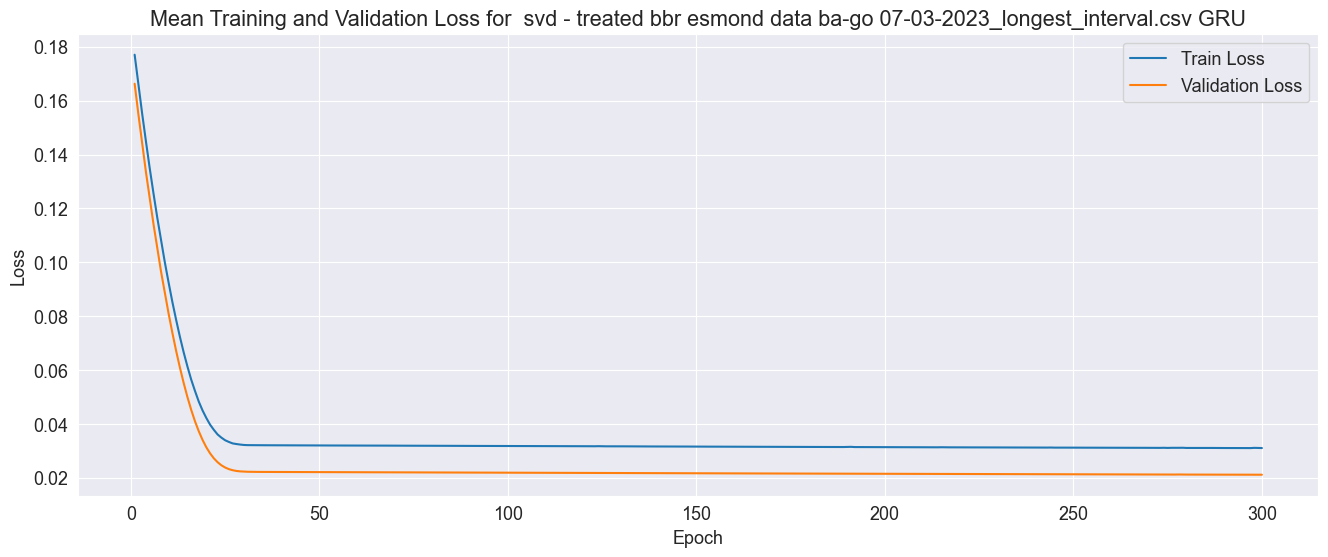

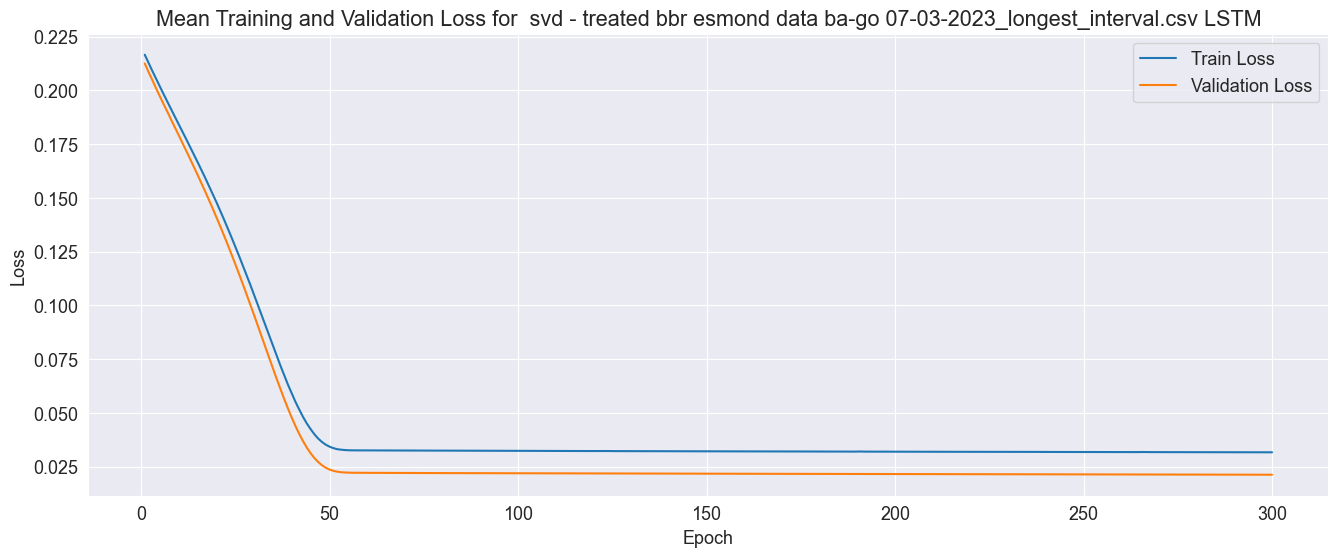

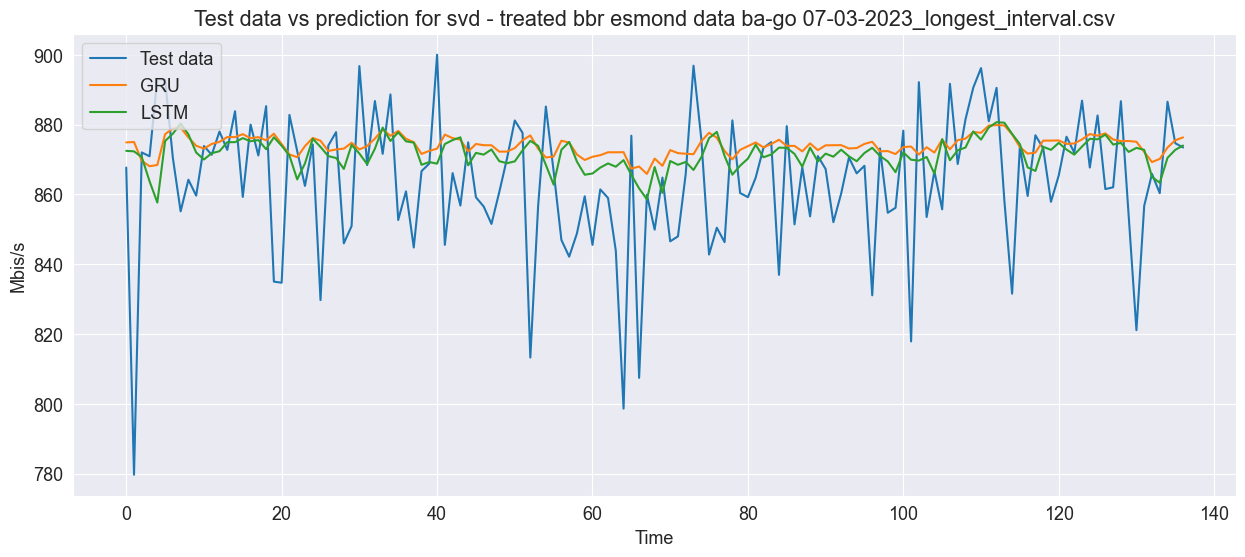

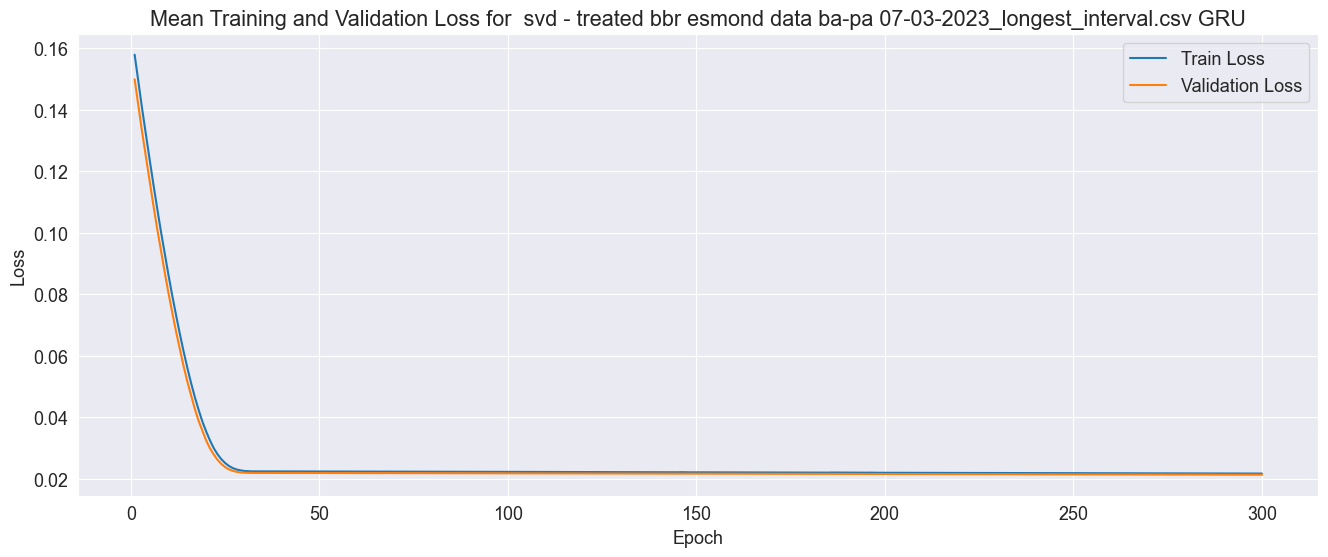

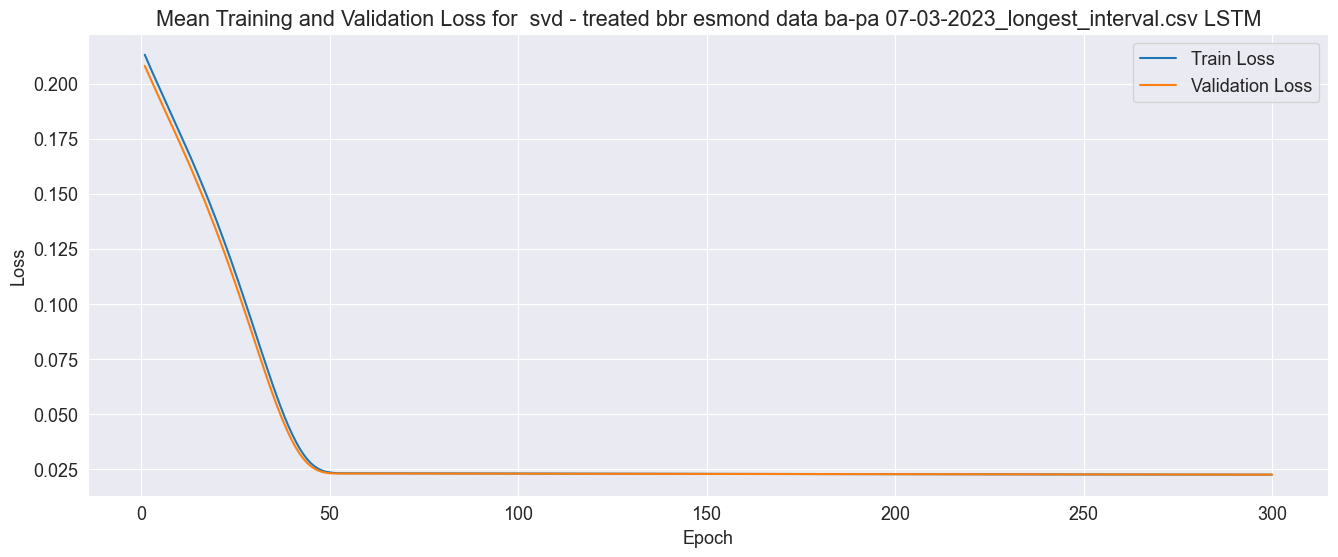

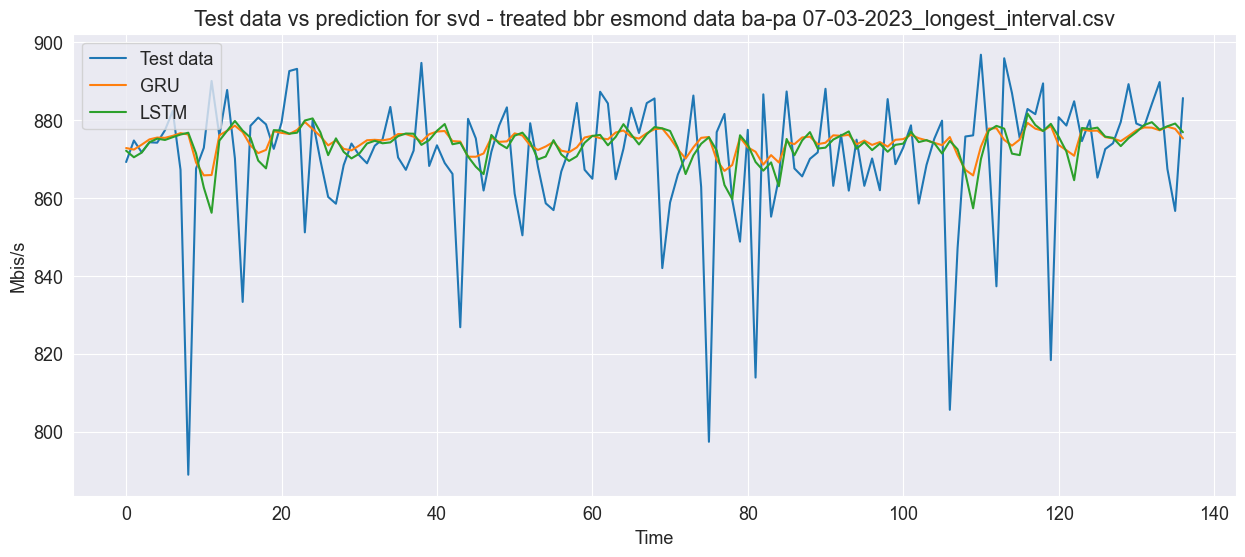

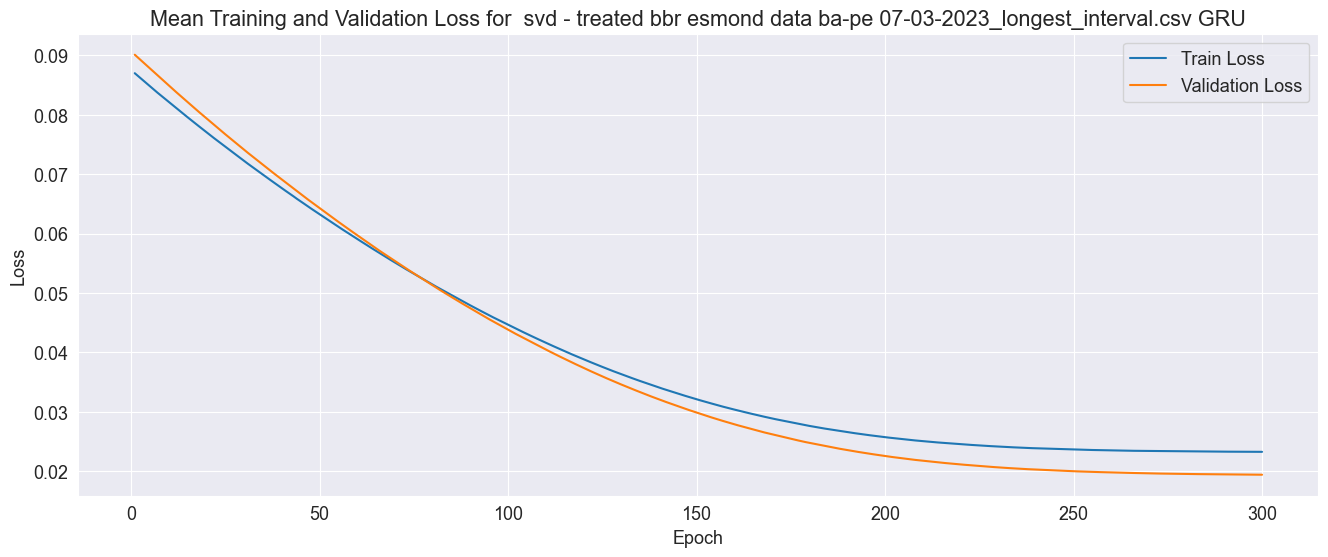

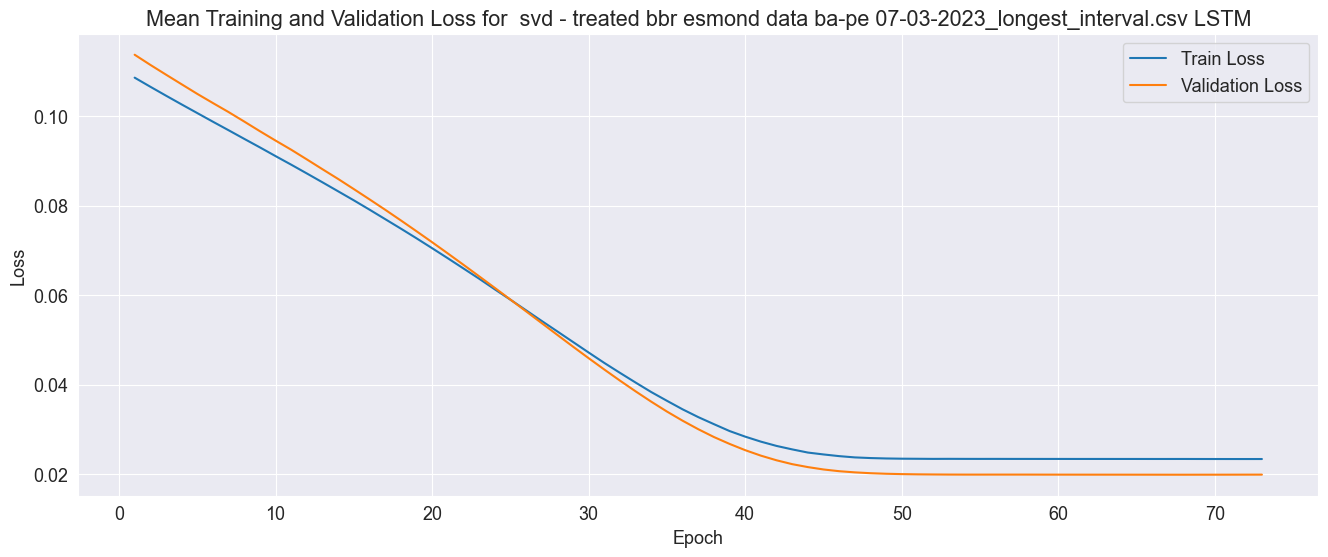

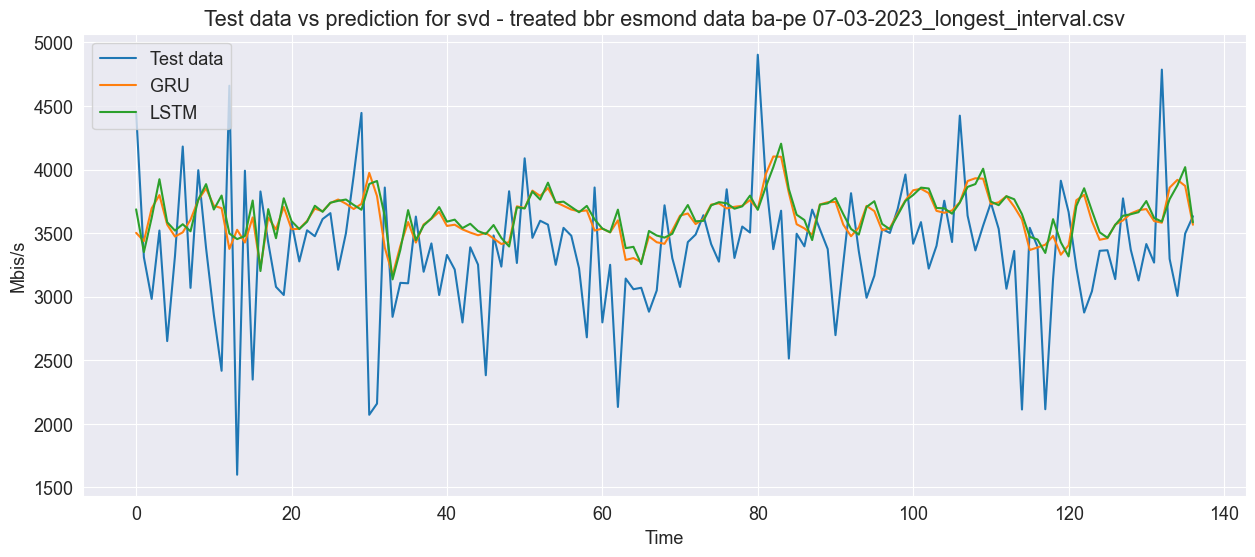

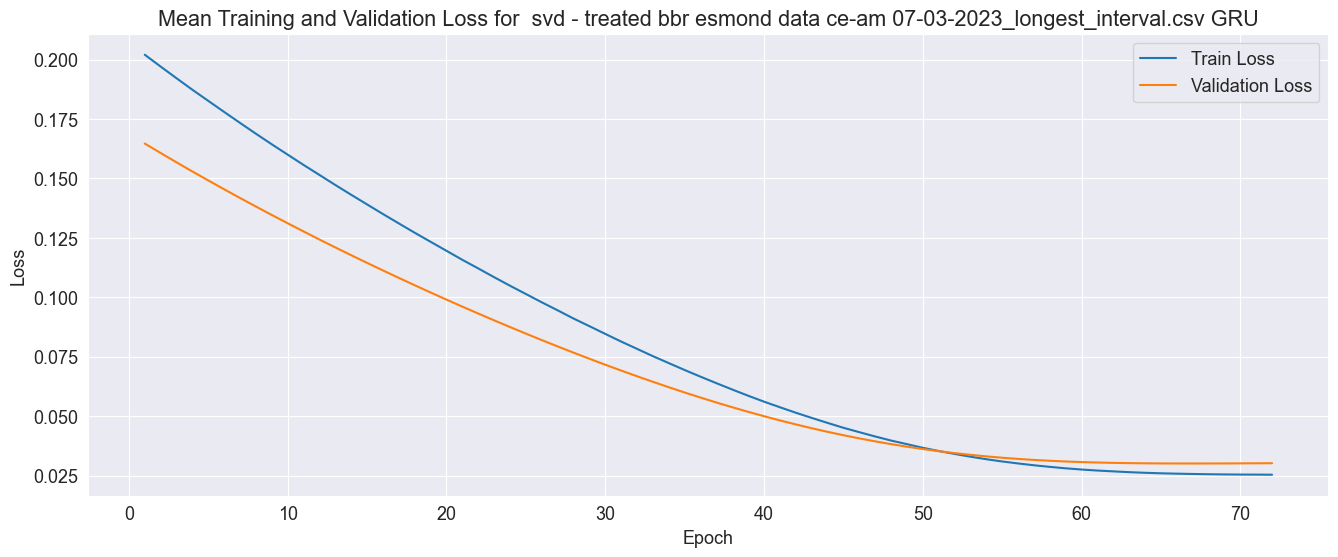

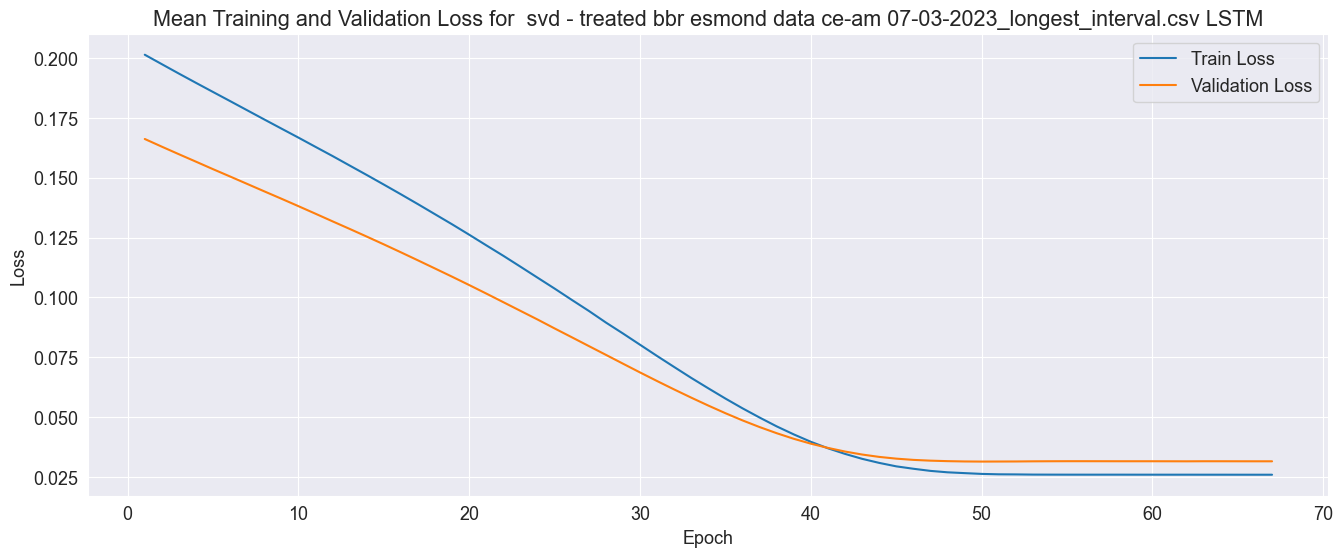

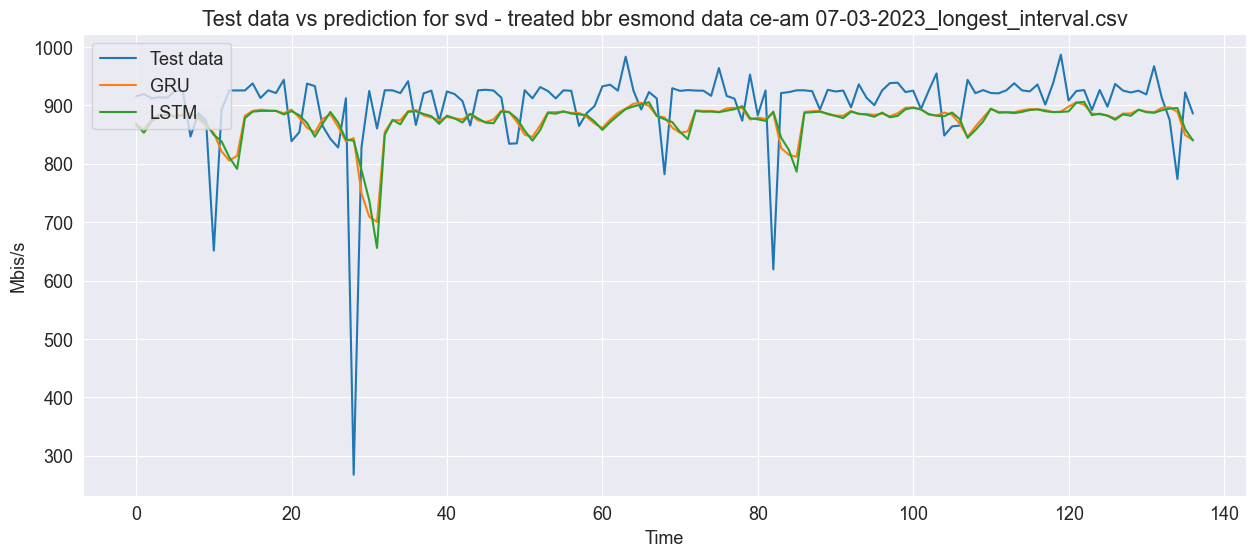

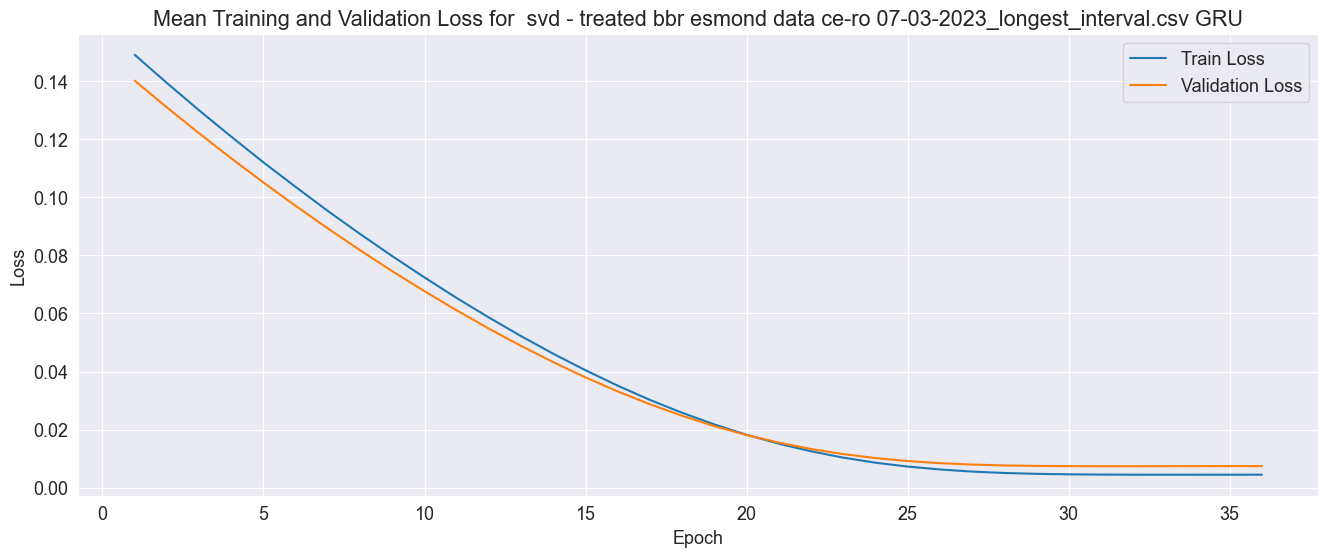

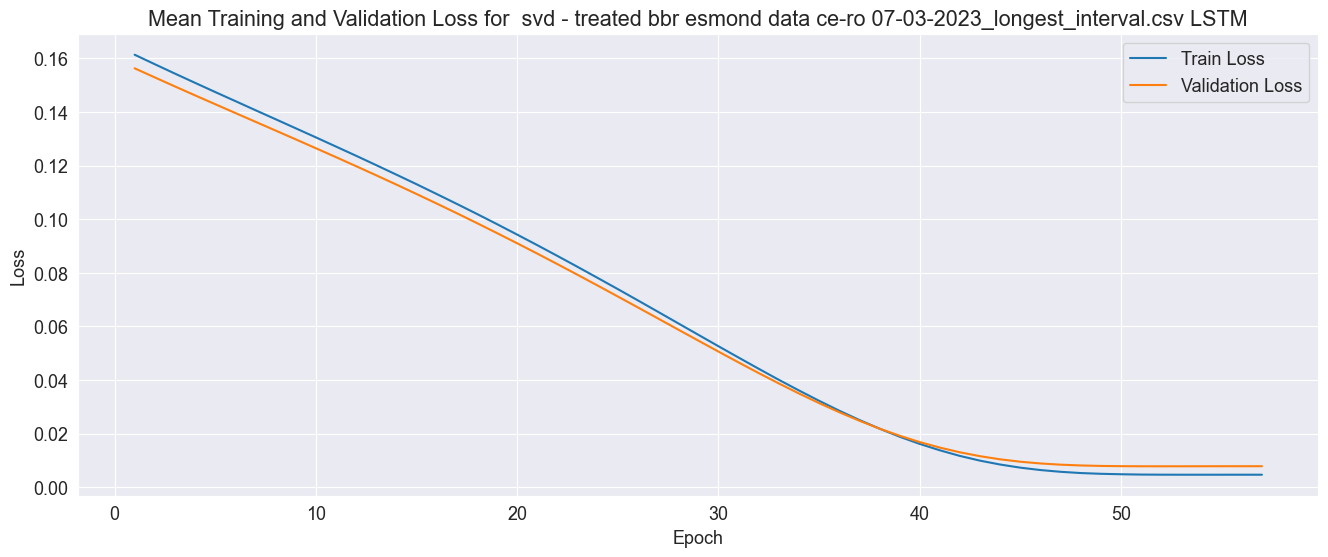

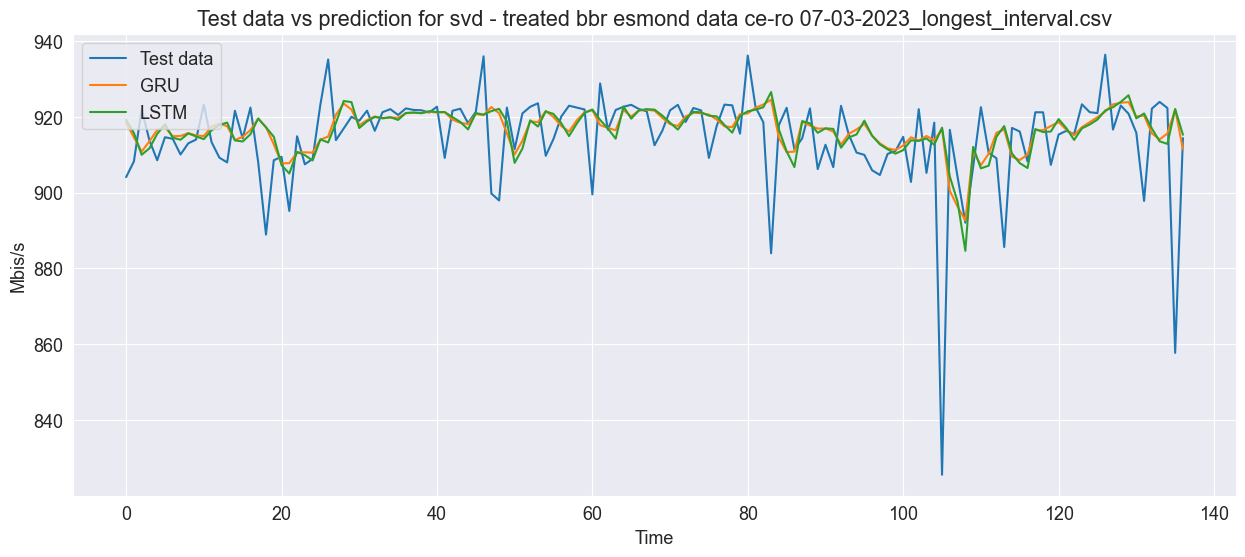

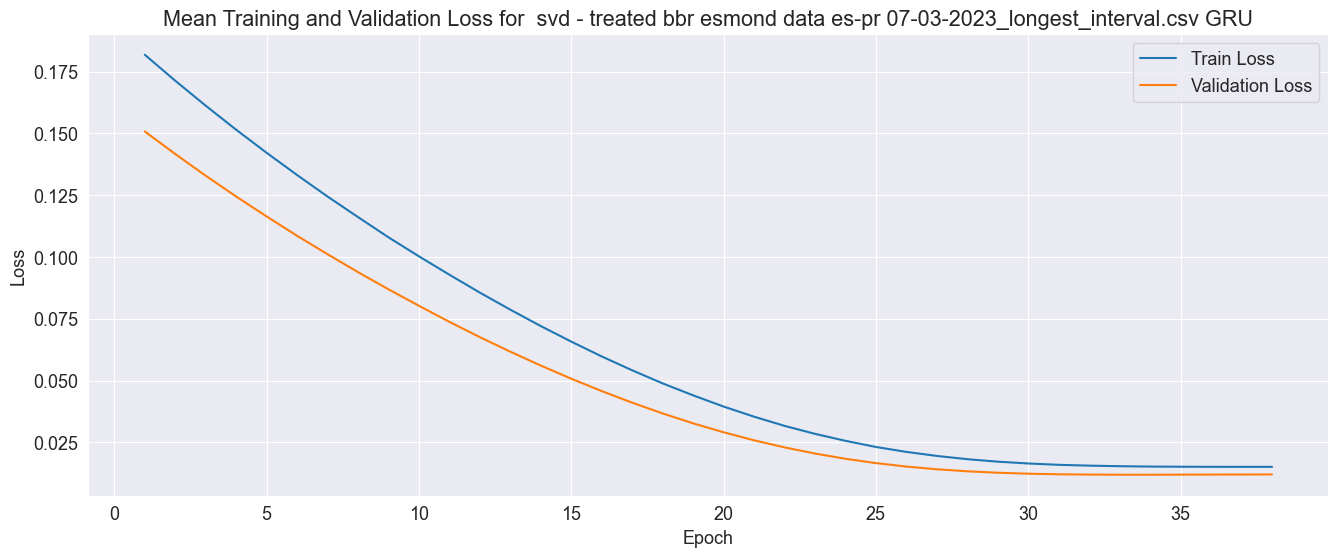

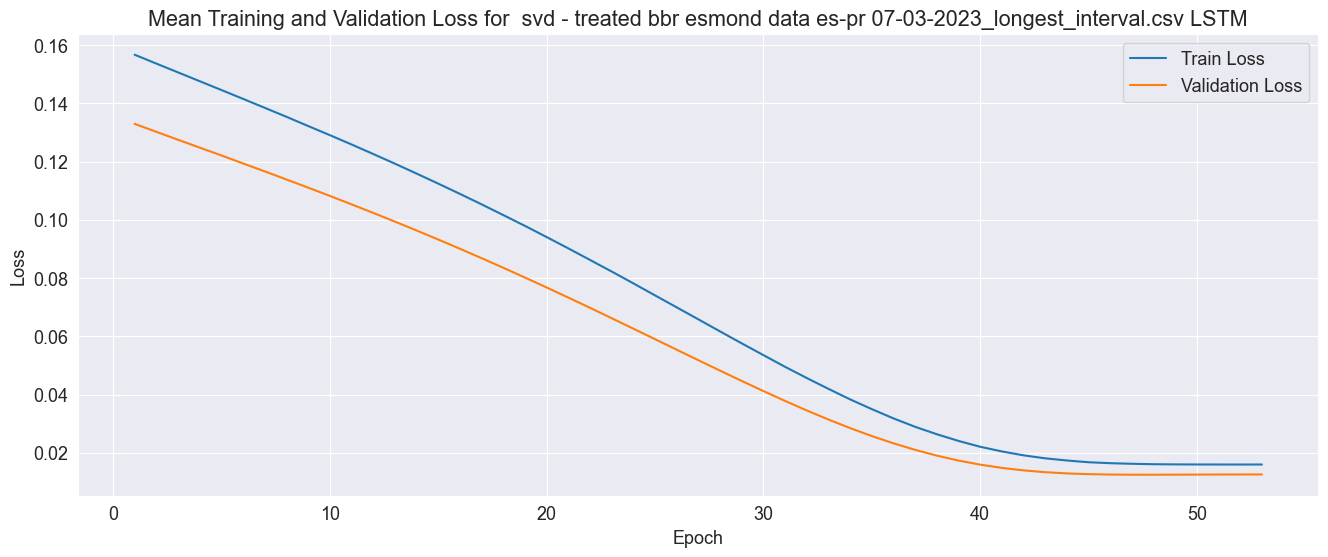

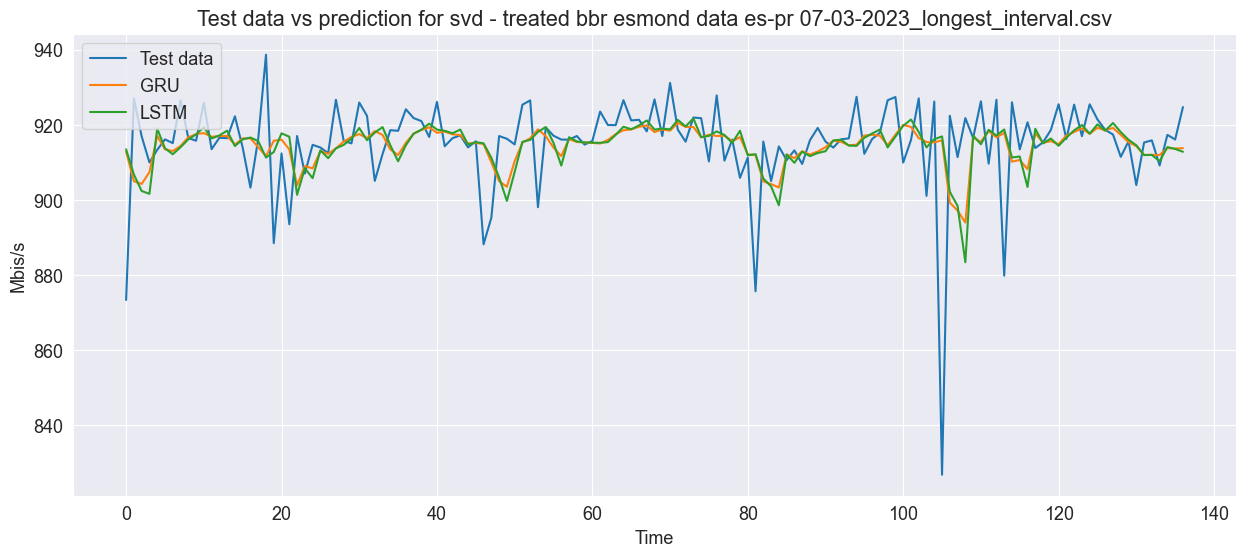

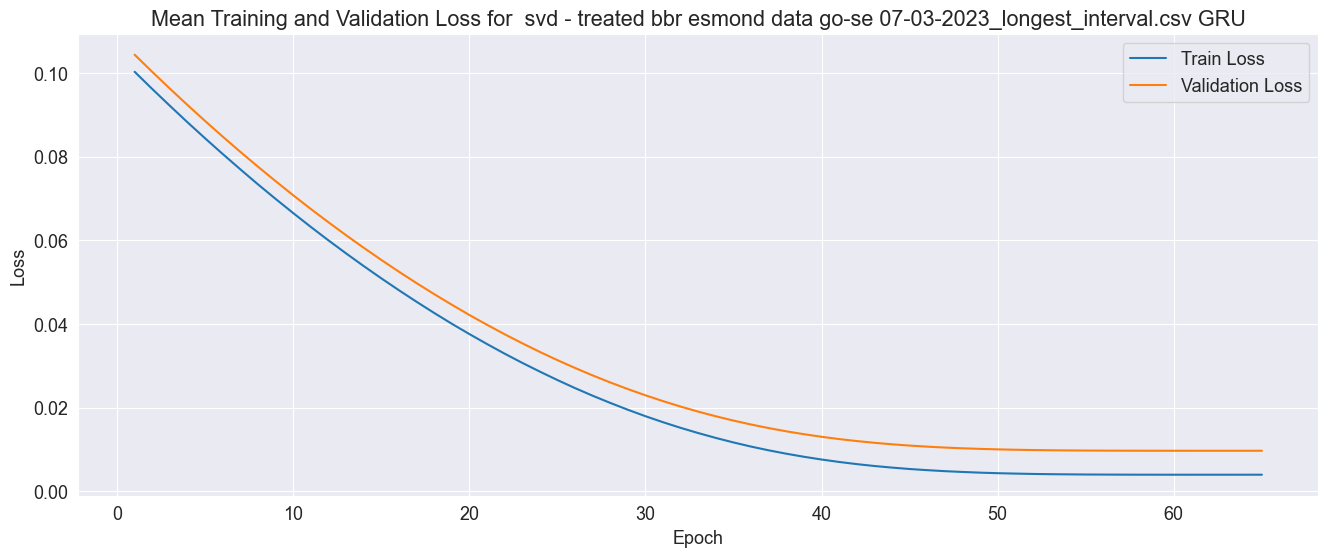

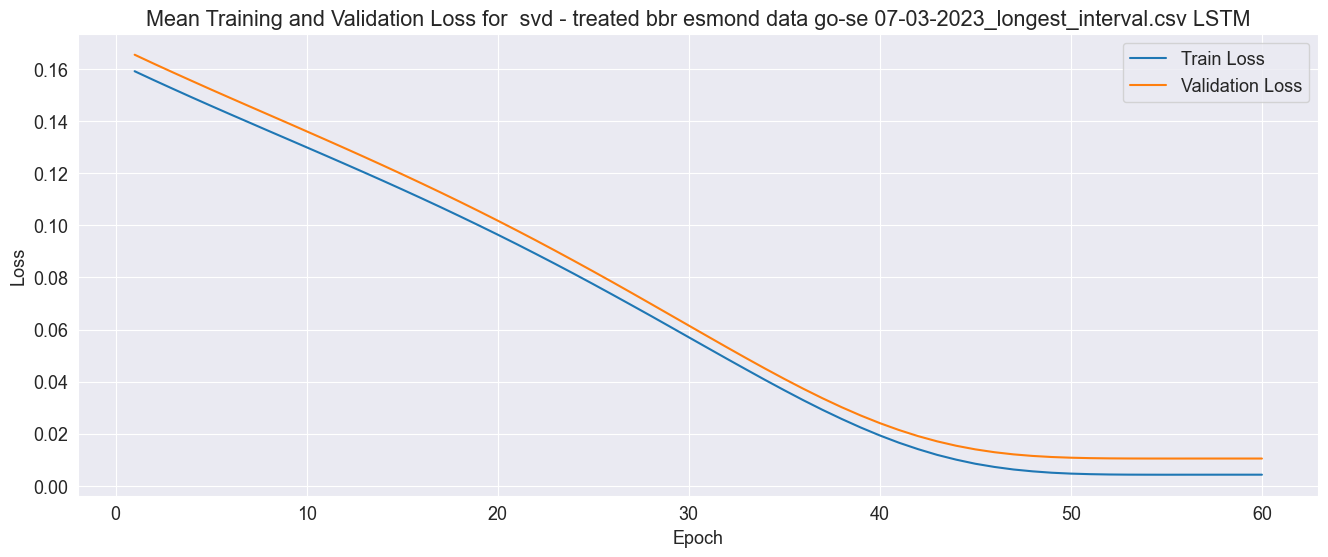

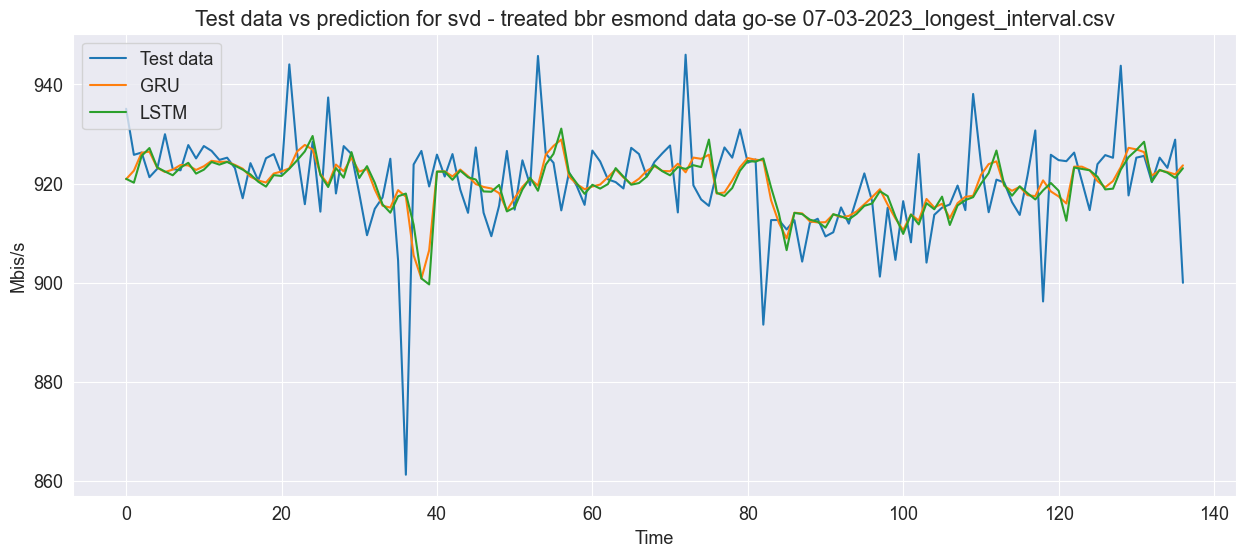

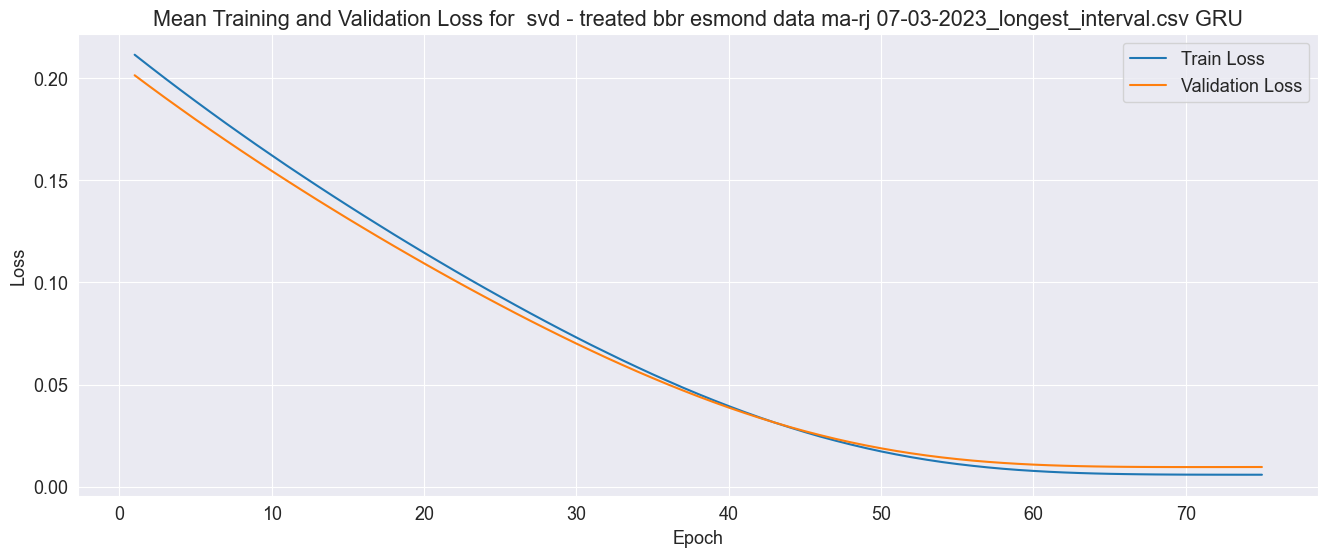

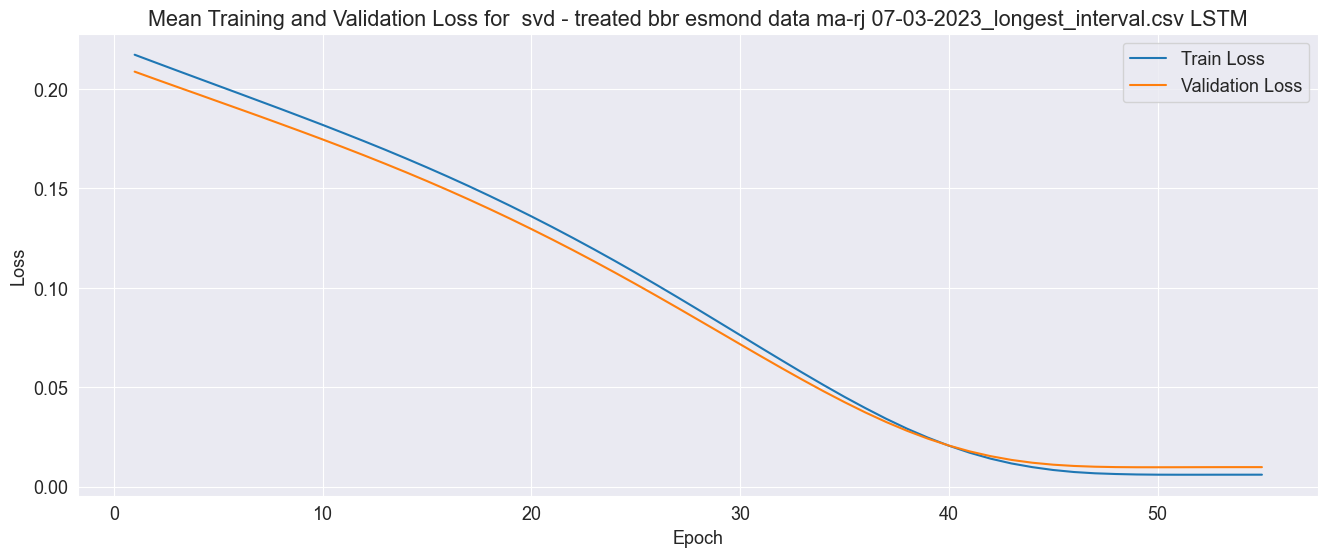

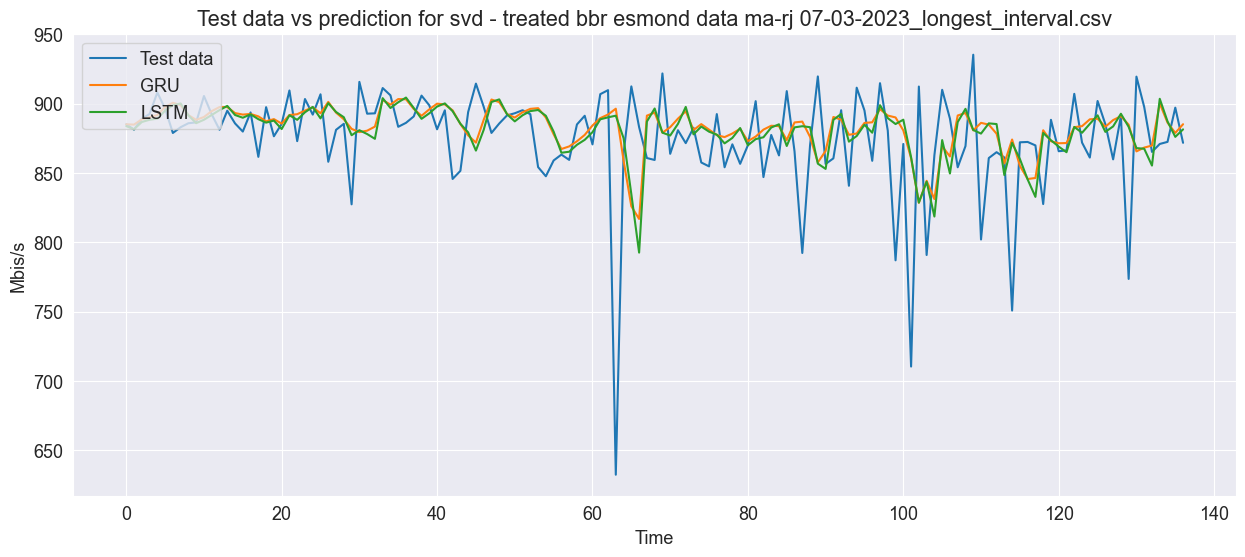

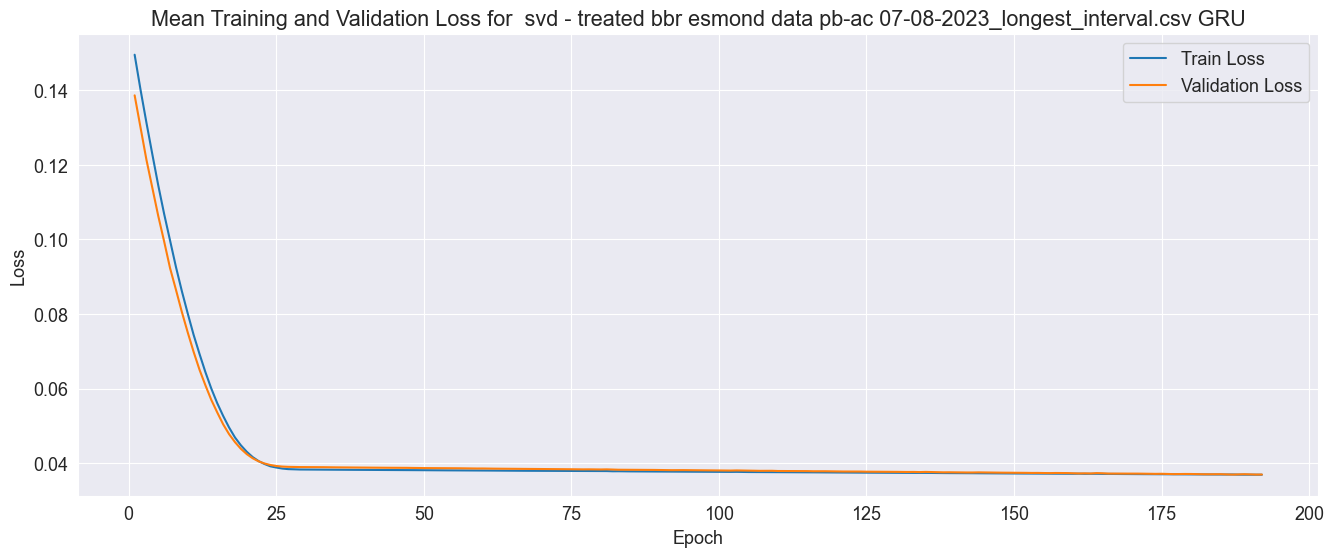

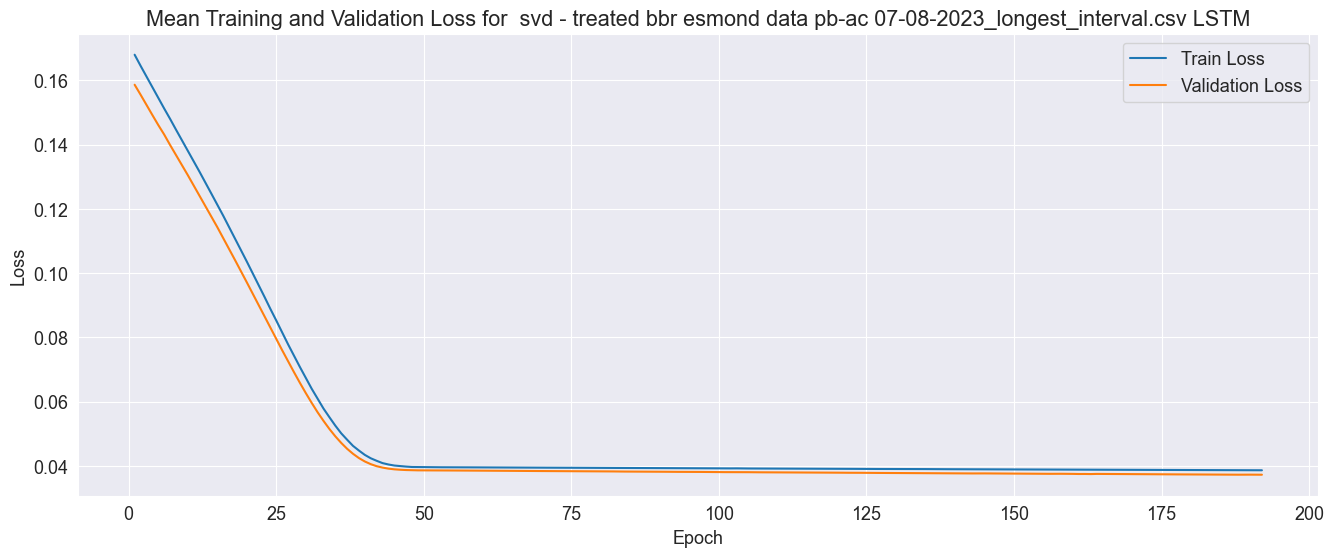

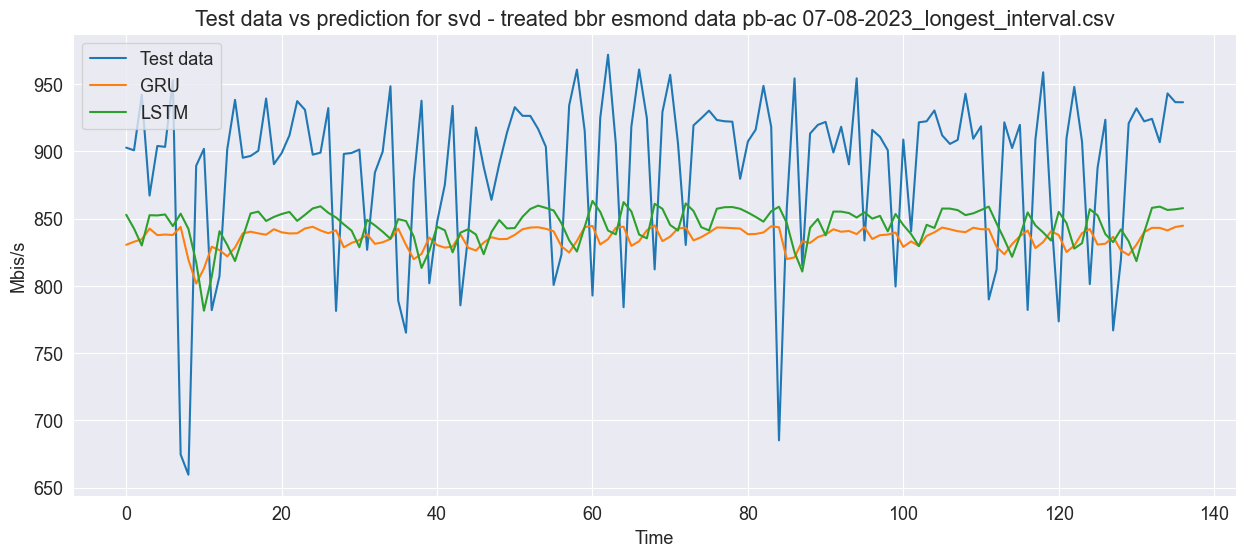

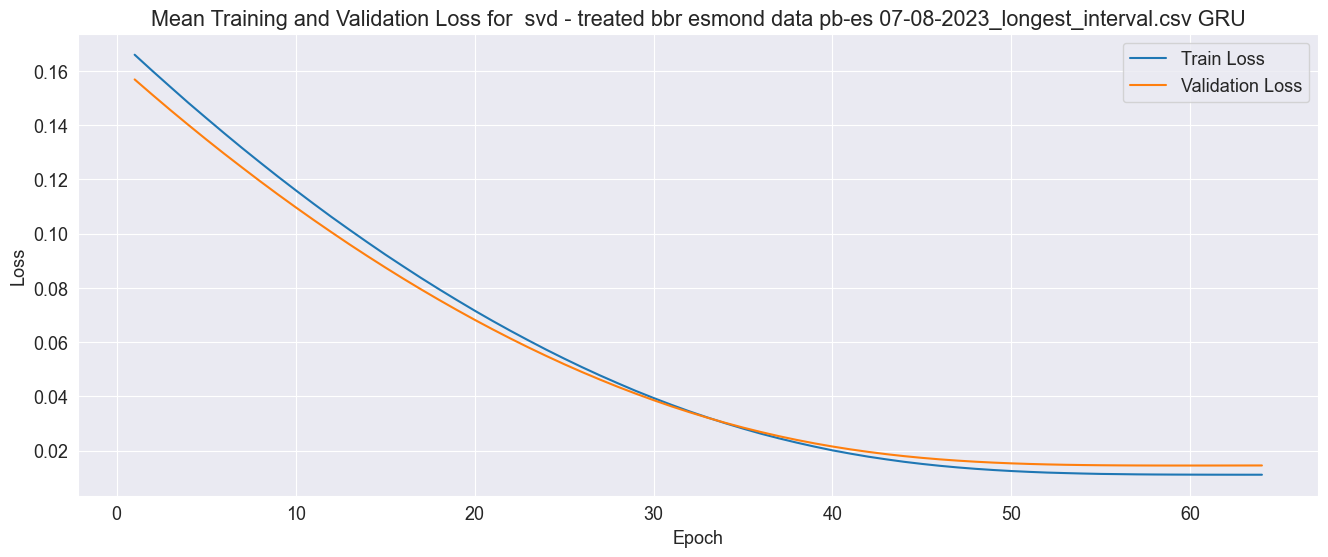

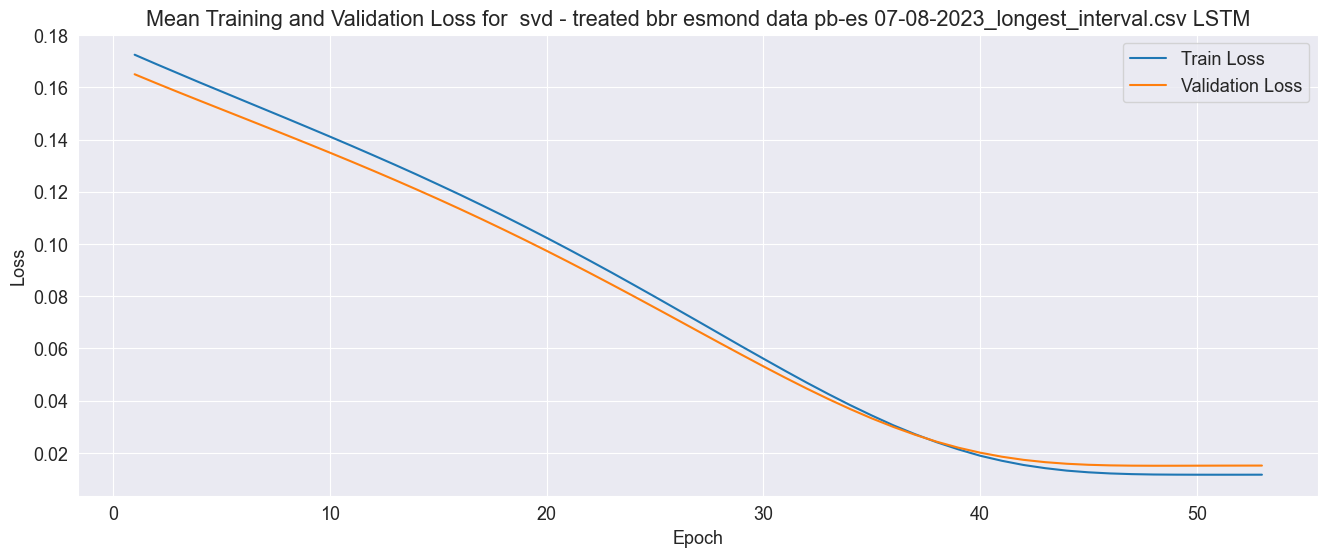

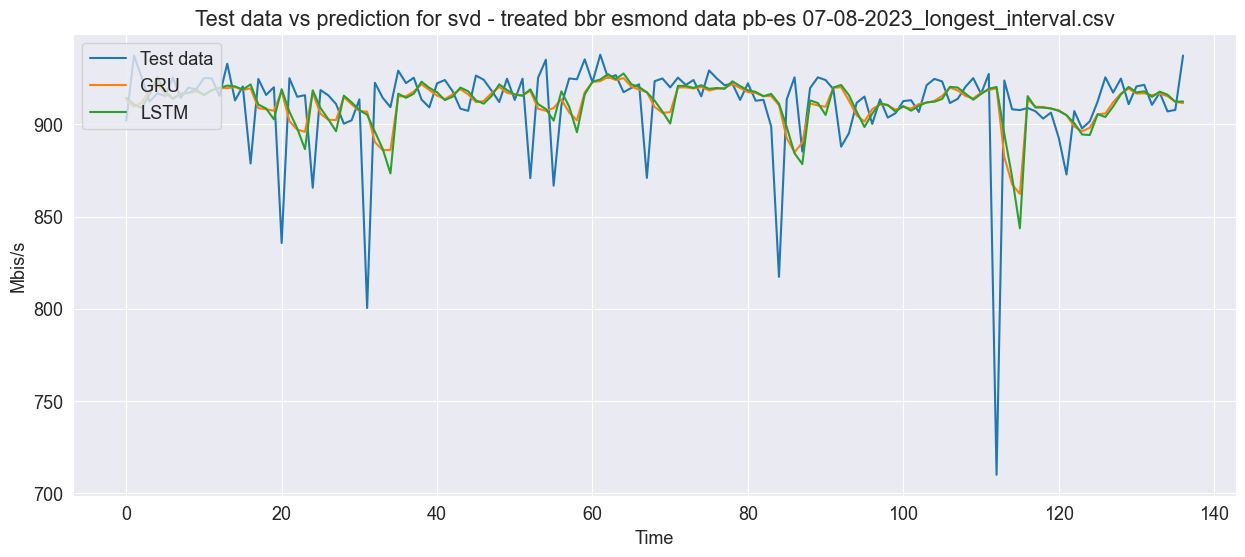

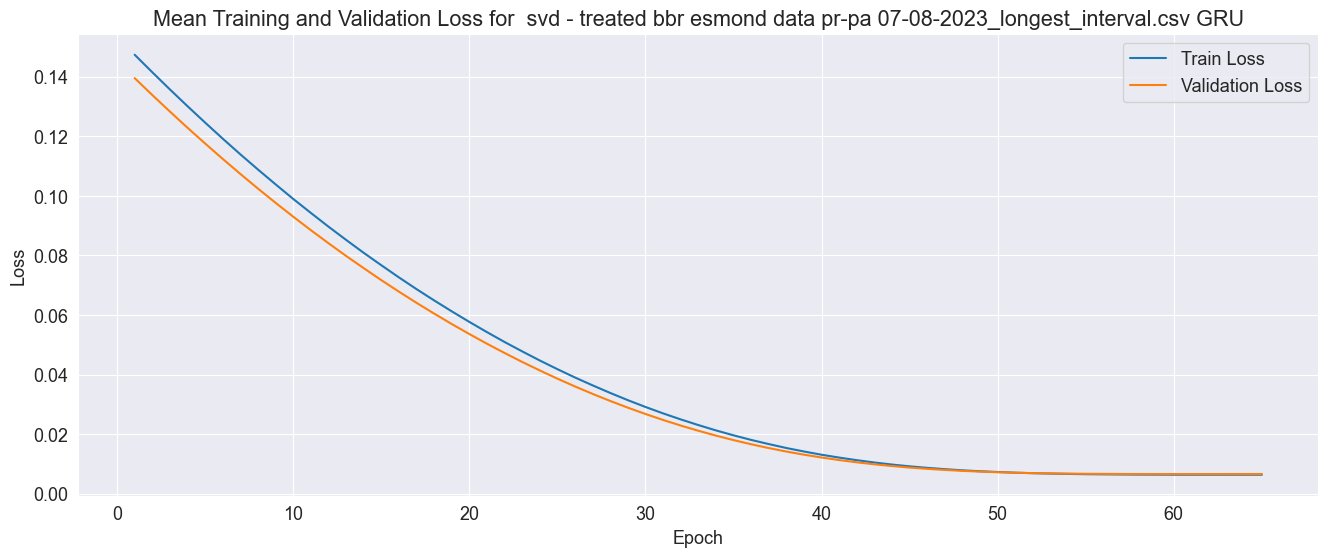

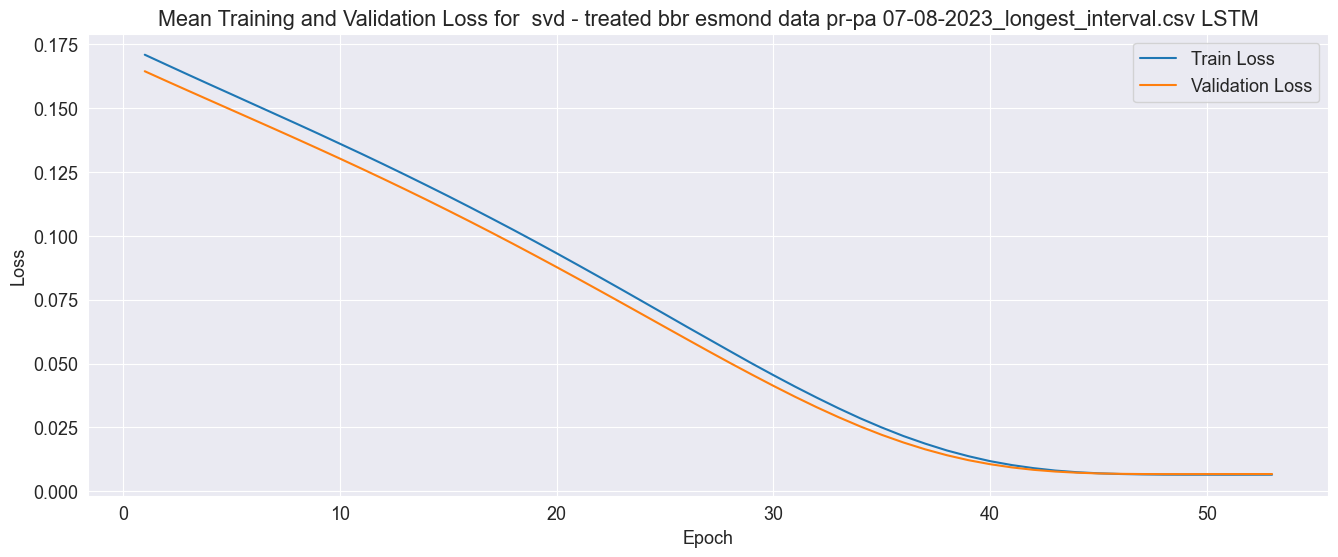

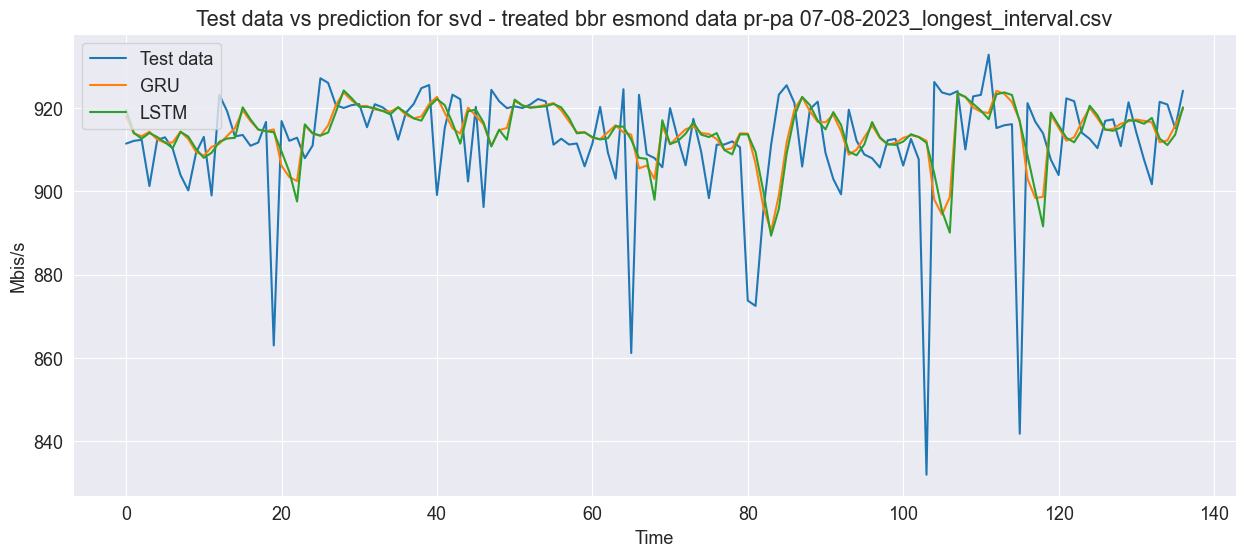

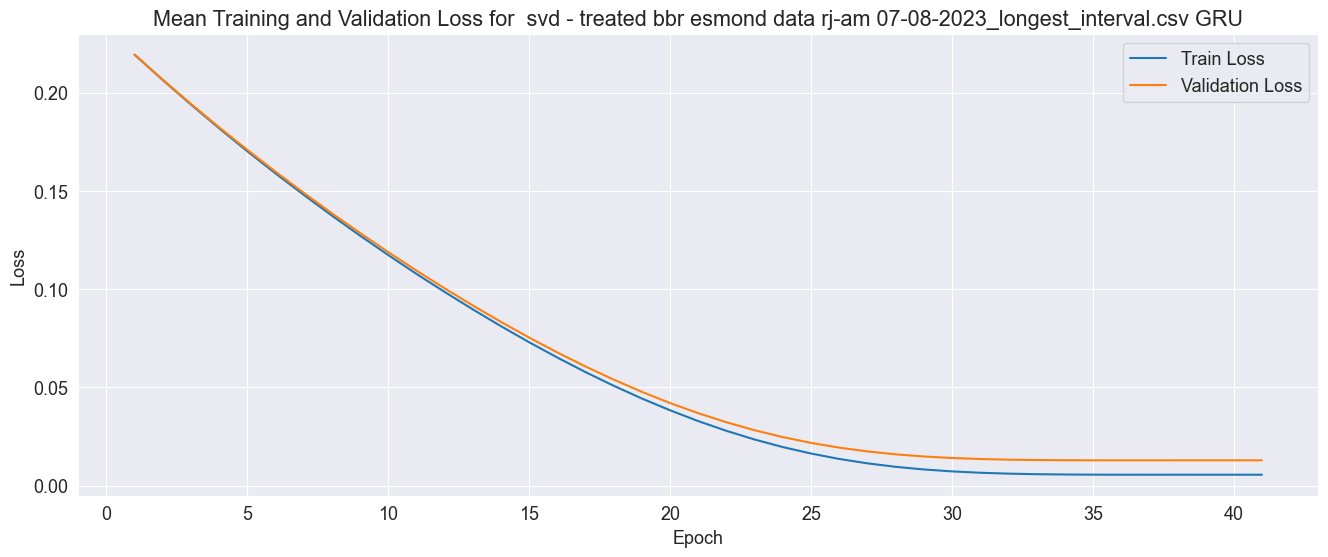

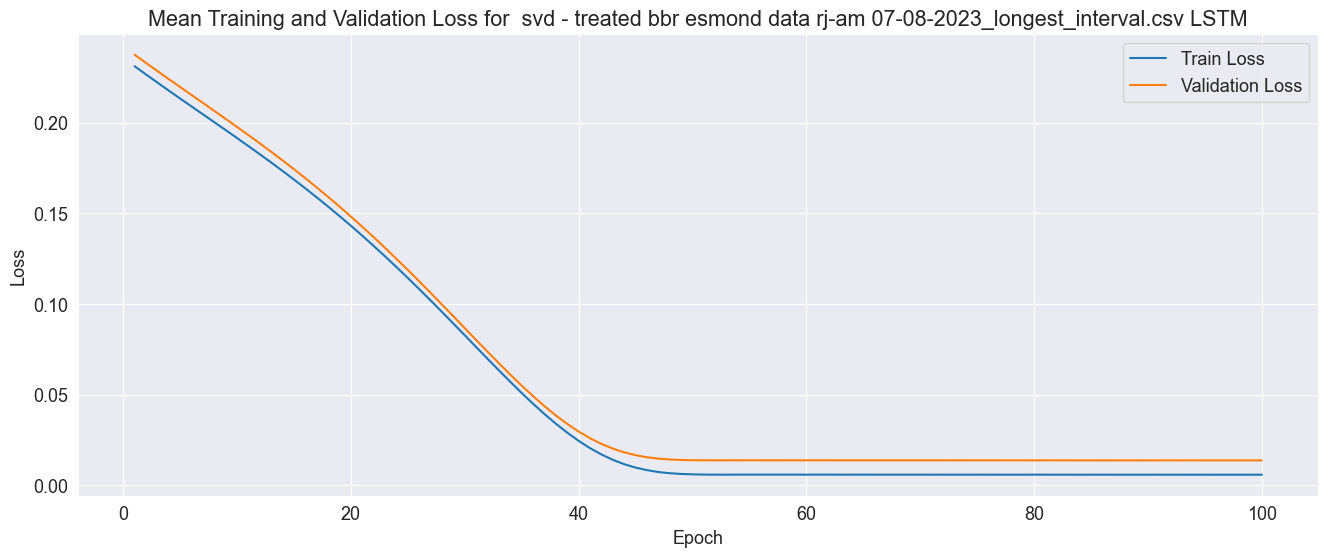

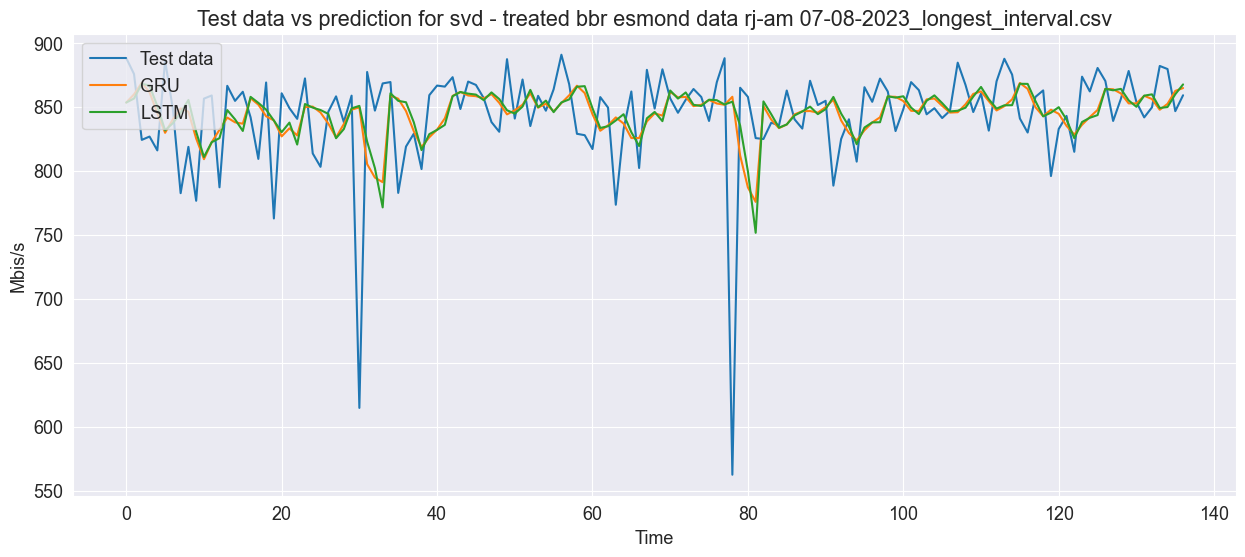

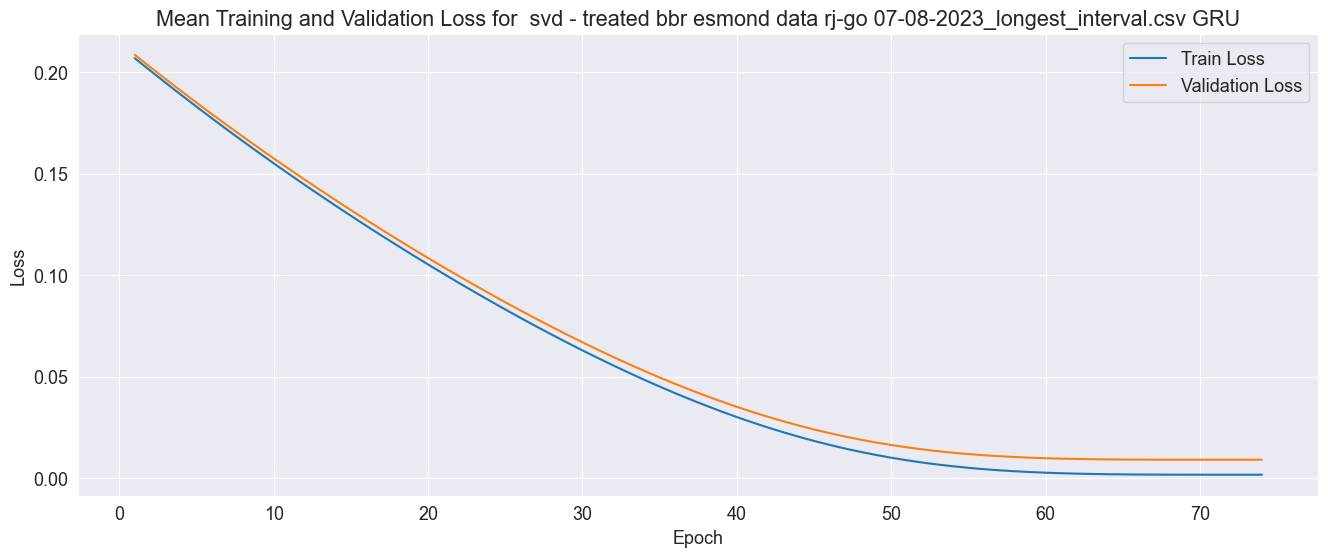

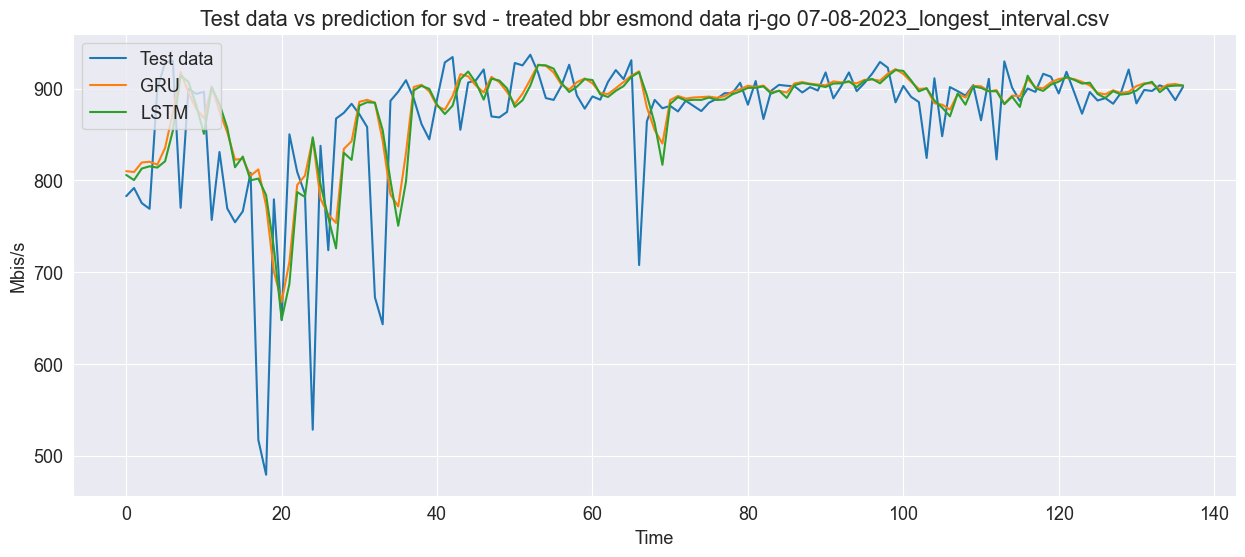

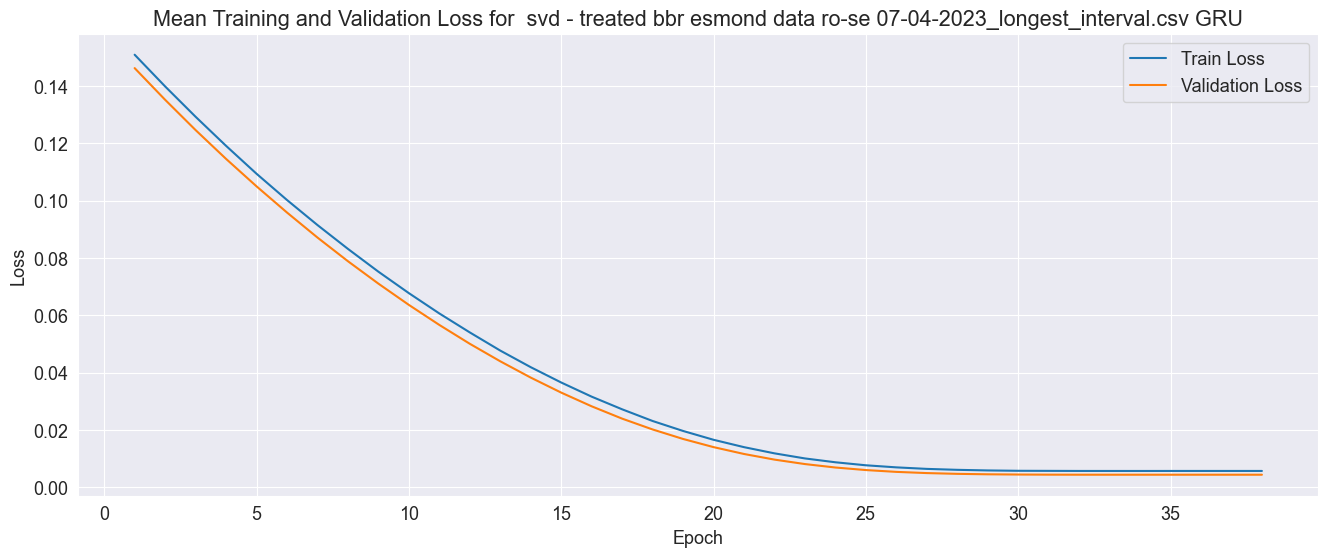

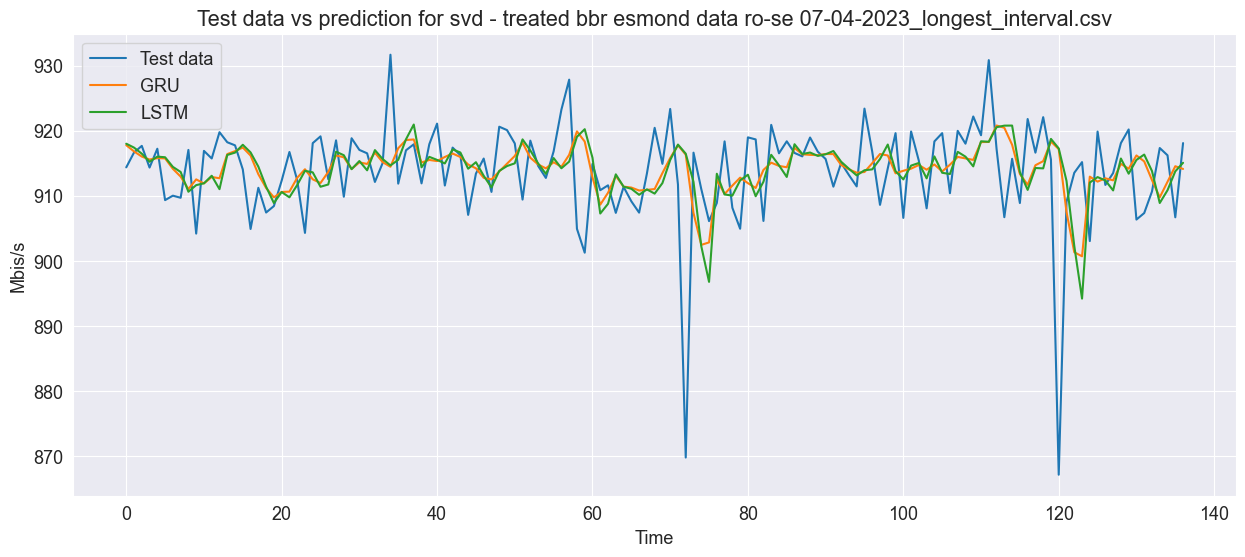

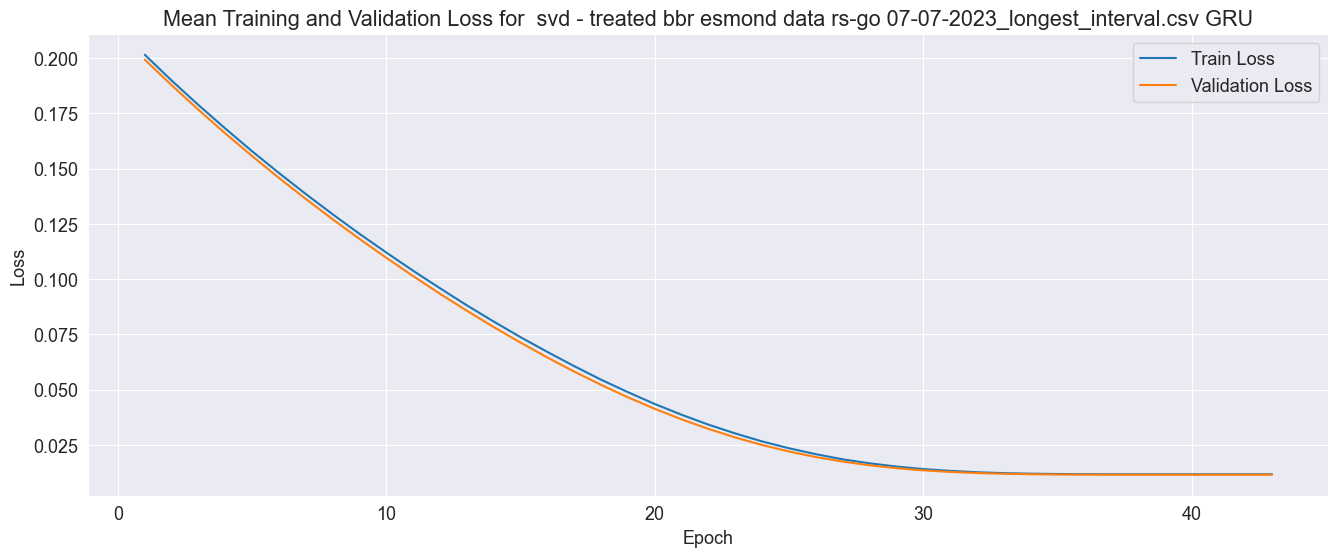

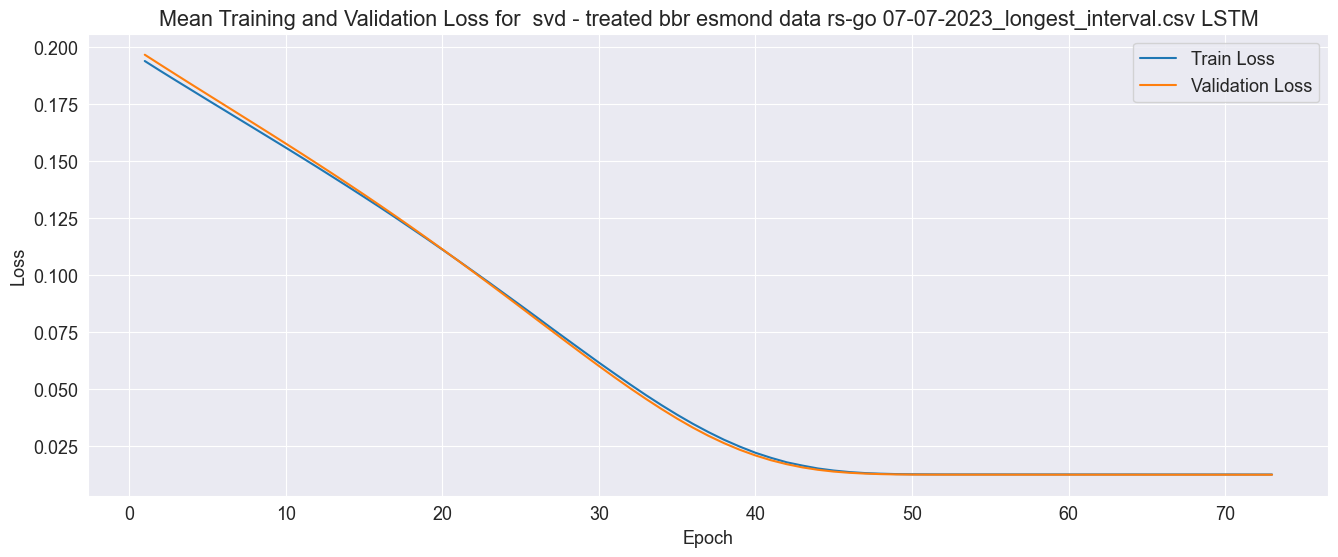

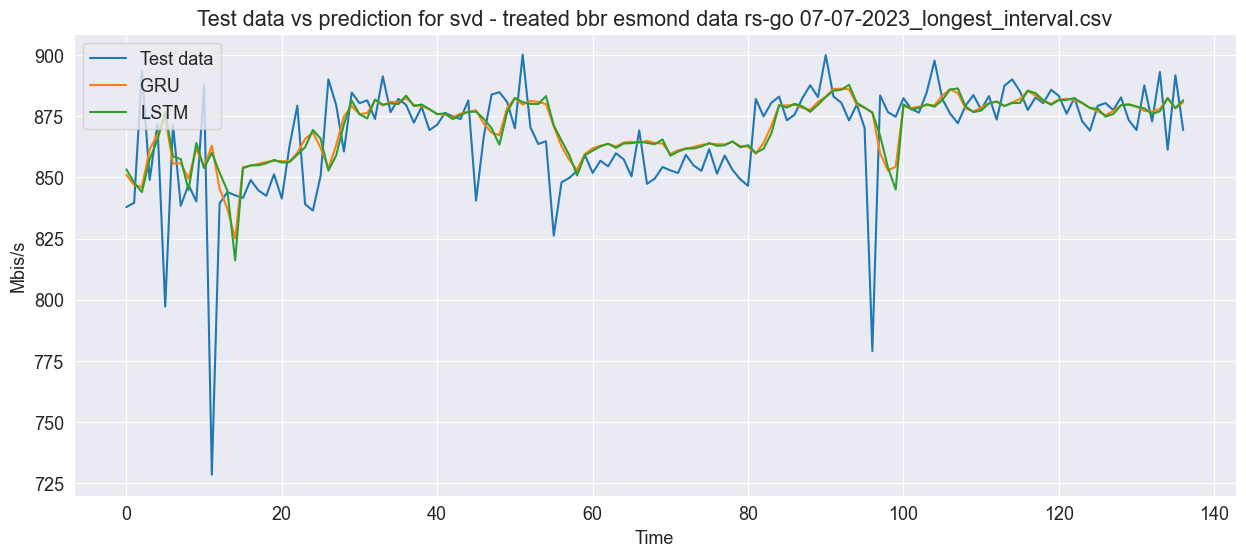

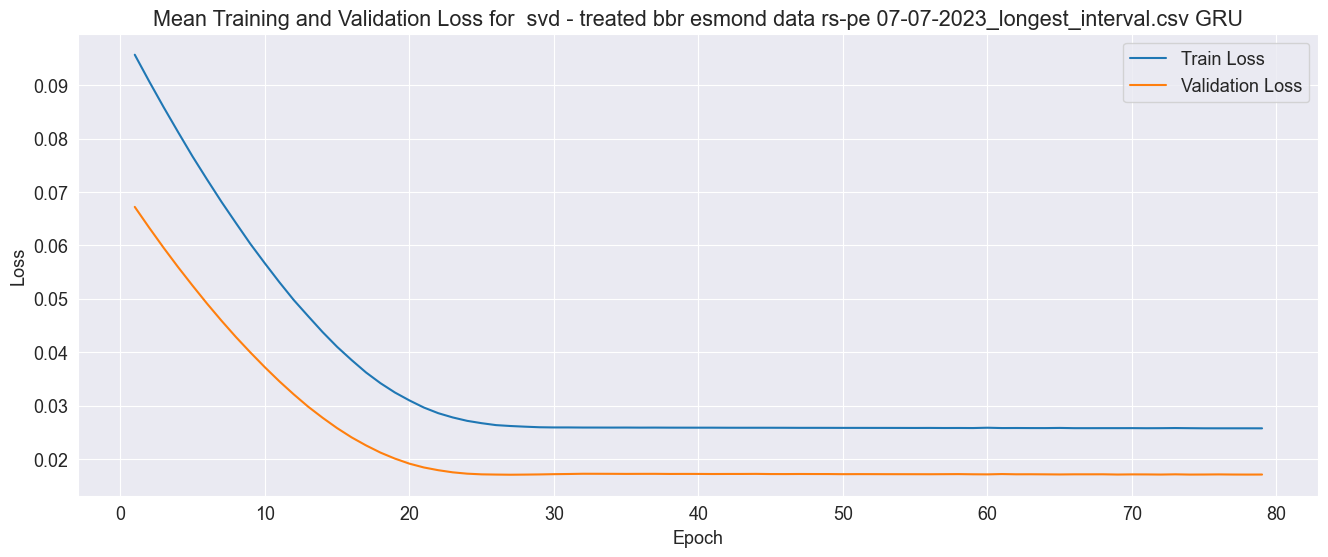

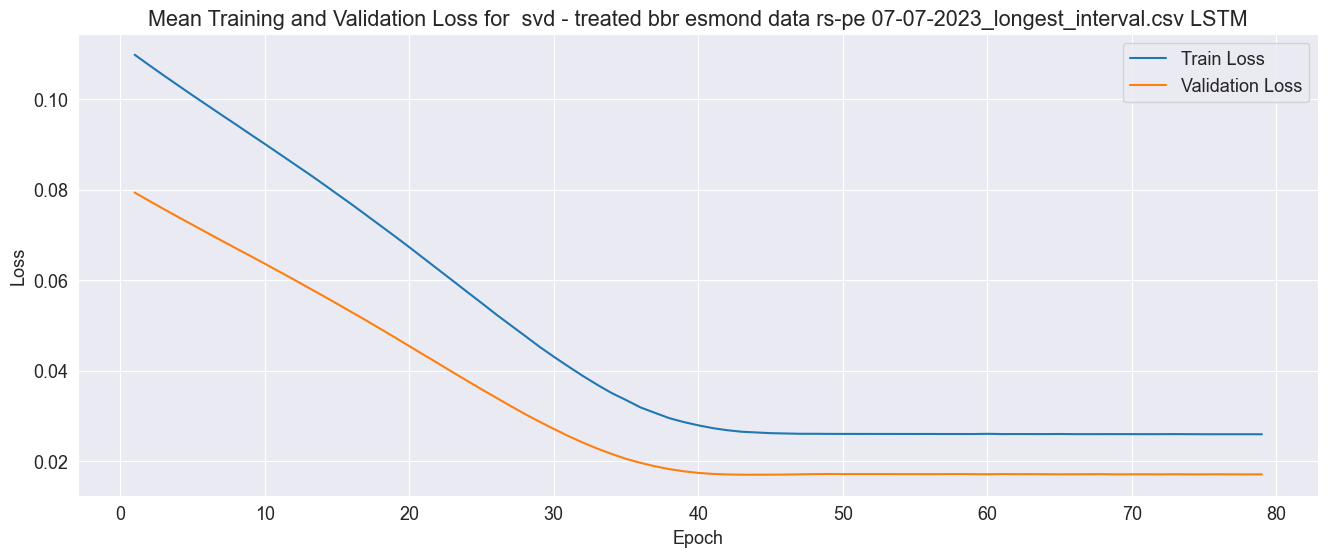

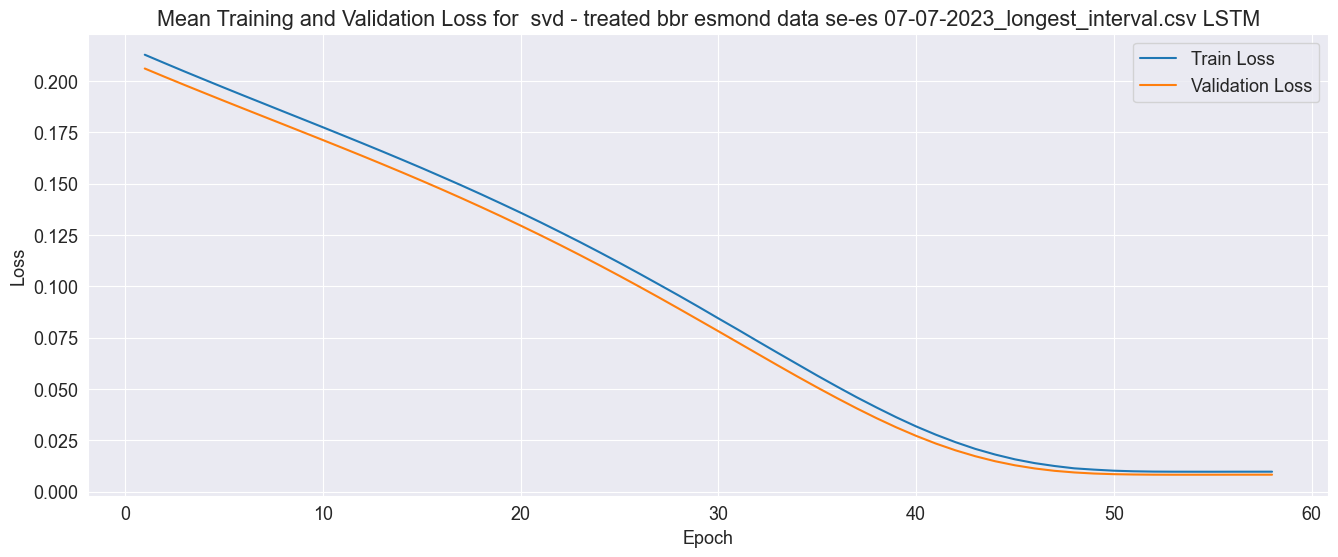

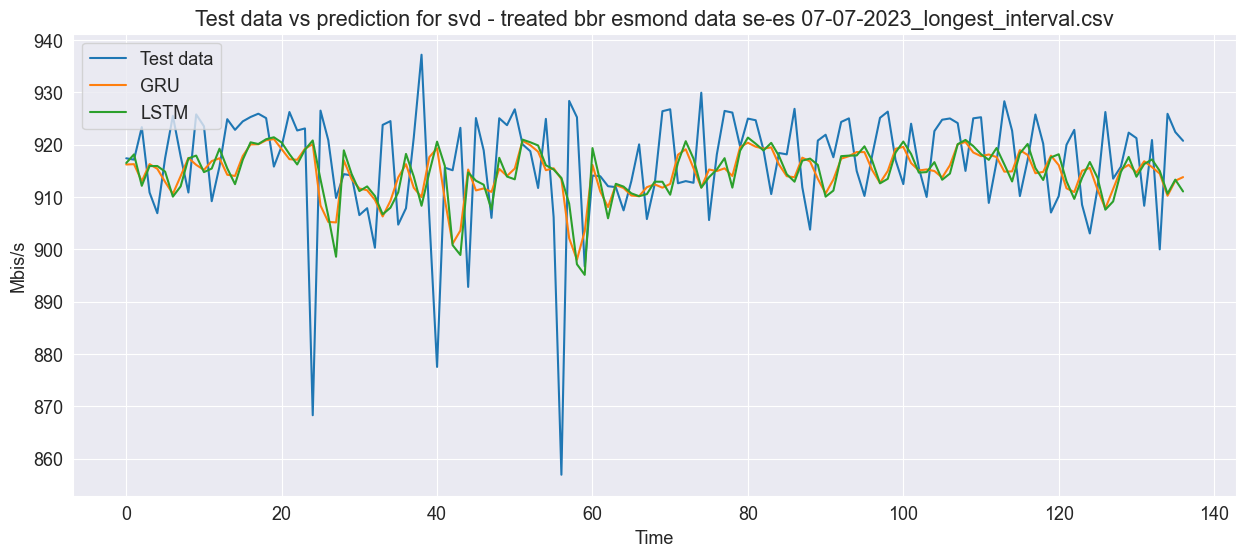

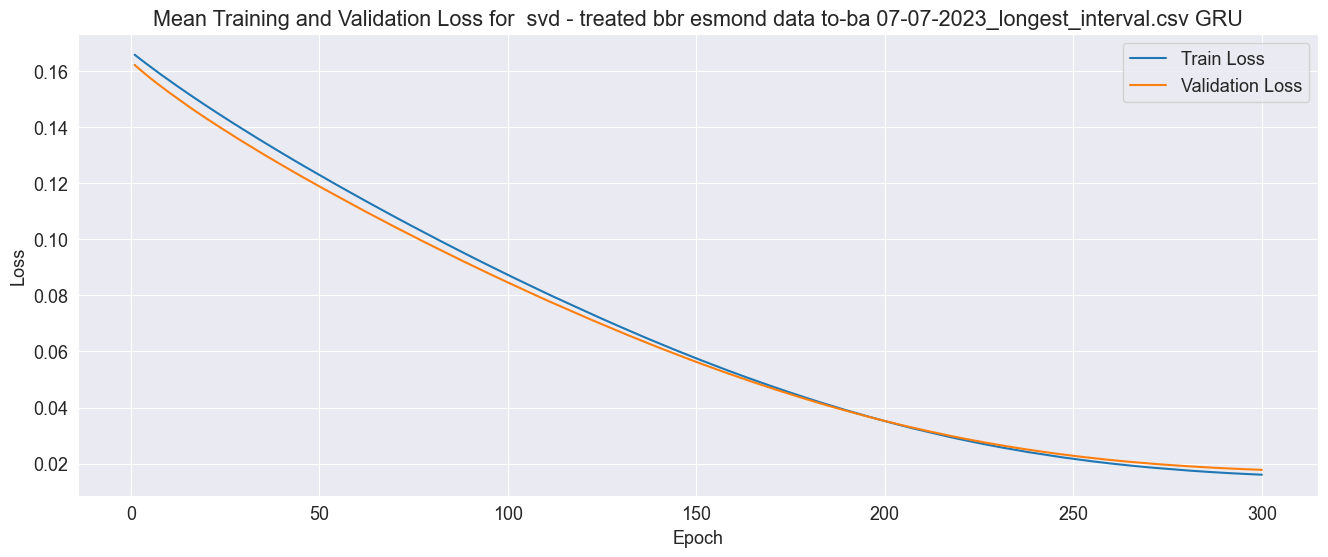

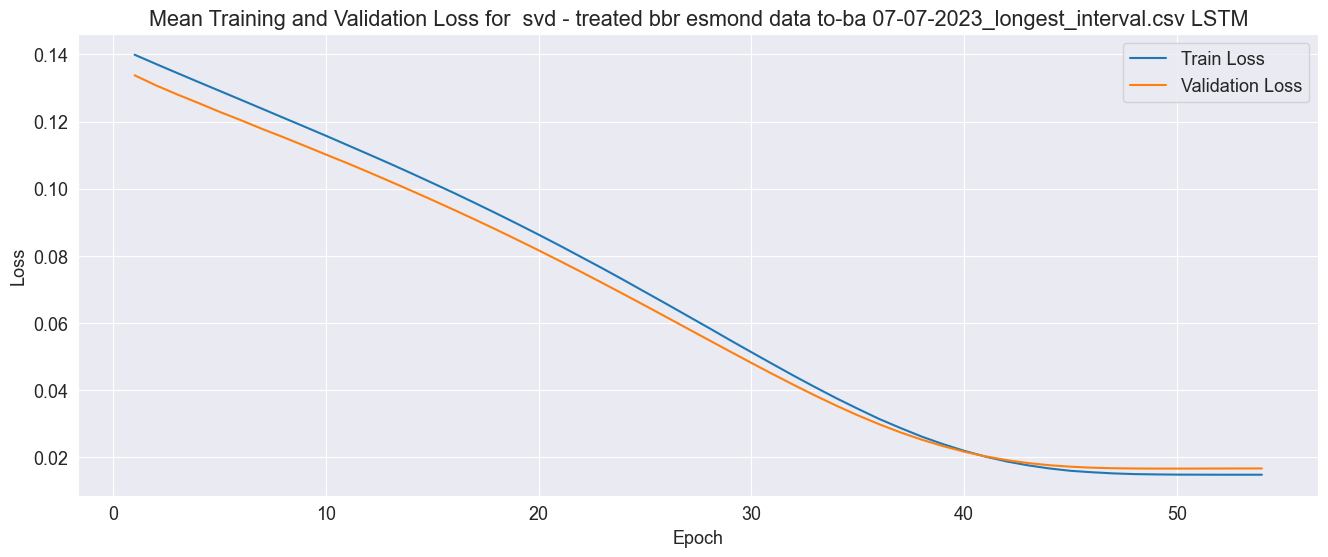

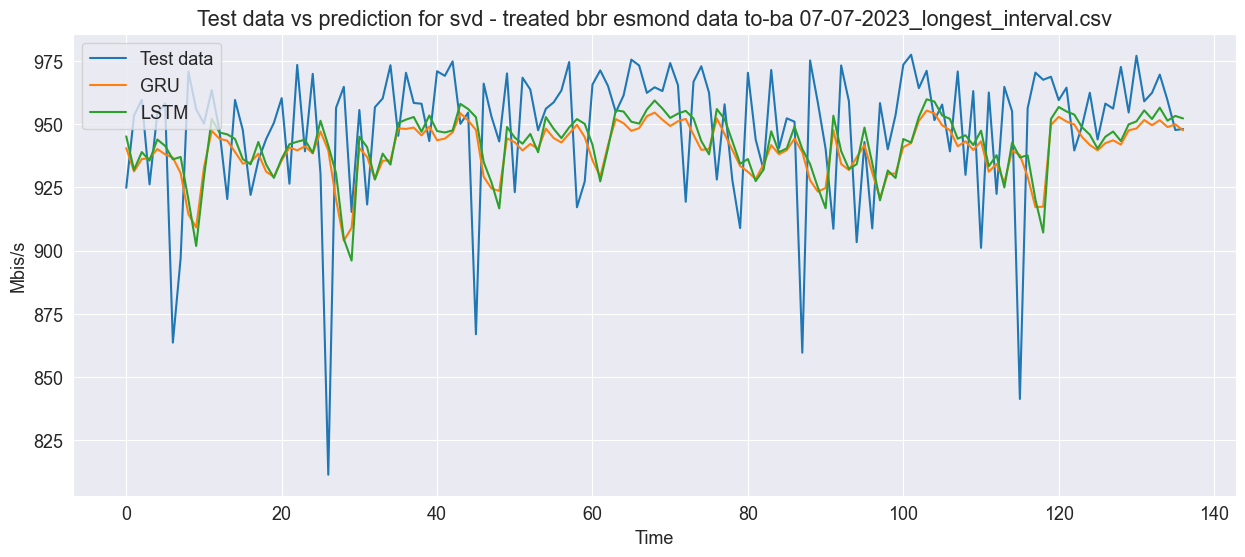

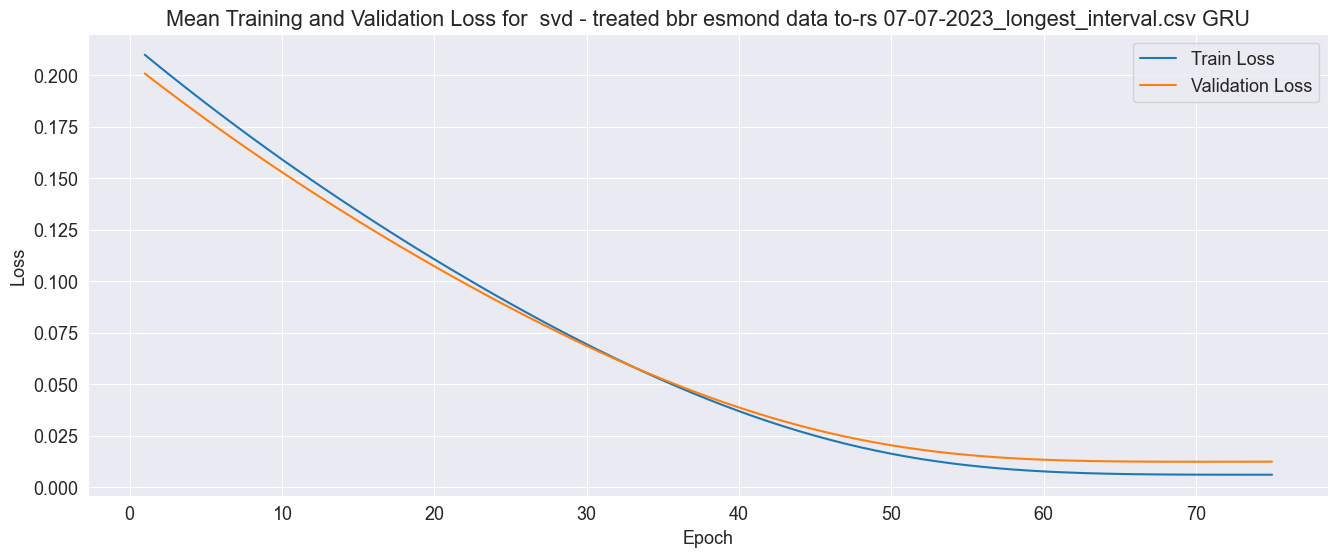

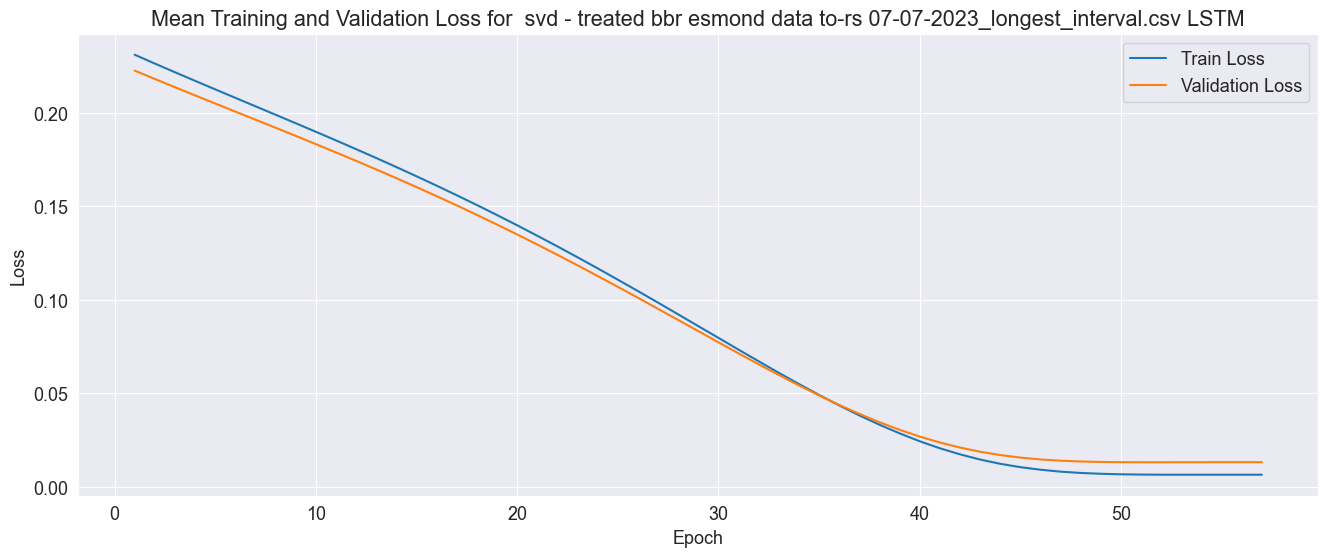

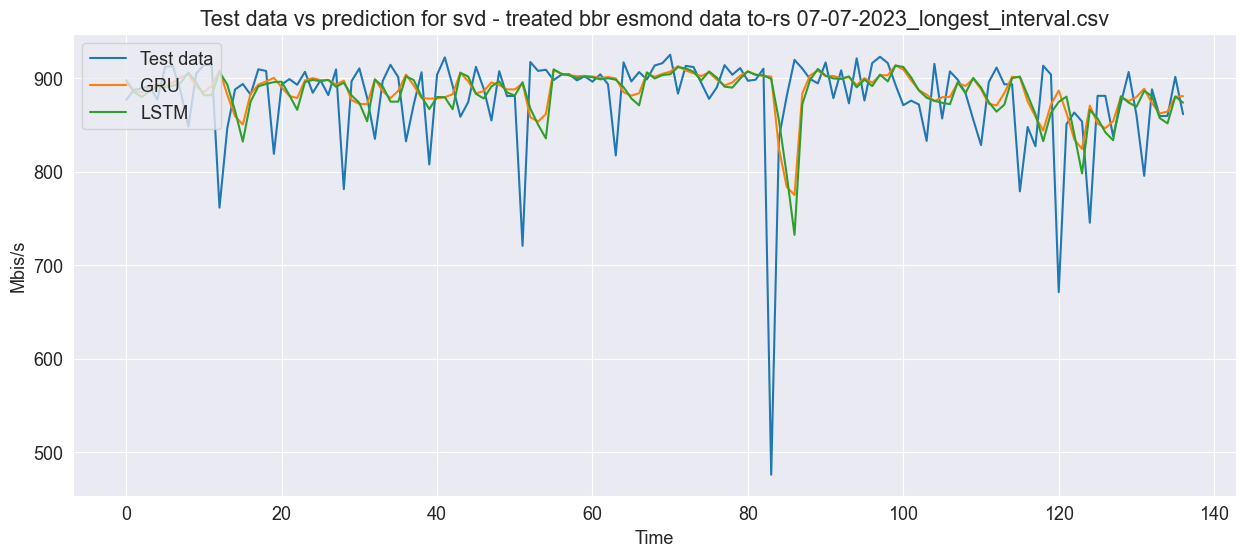

In [6]:
#salvando as saidas em um arquivo externo para analise 
import sys

# Redirecionar saída padrão para um arquivo com codificação utf-8
orig_stdout = sys.stdout
f = open('training_output.txt', 'w', encoding='utf-8')
sys.stdout = f

# Model Trainnig and Prediction
import os
import re
#treinamento e predição
# Defina o diretório raiz onde deseja iniciar a busca
diretorio_raiz = '..\\..\\datasets\\svd-imputed-choosen-best-svd\\'

evaluation = {}

# Itere pelos diretórios e subdiretórios
for pasta_raiz, subpastas, arquivos in os.walk(diretorio_raiz):
    for arquivo in arquivos:
        # Verifique se o arquivo é um arquivo CSV
        if arquivo.endswith('.csv'):
            # Construa o caminho completo para o arquivo
            caminho_arquivo = os.path.join(pasta_raiz, arquivo)
            # print(caminho_arquivo)

        try:
                # Título parser
                # partes = caminho_arquivo.split("\\")
                # if len(partes) >= 2:
                # #     substring_desejada = "/".join(partes[1:])  # Acesse as partes a partir da segunda e as una com barras invertidas
                
                partes = caminho_arquivo.split("\\")
                print(partes)
                substring_desejada = partes[4] + ' - ' + partes[5]  # Acesse as partes a partir da segunda e as una com barras invertidas
                
                #df = pd.read_csv(caminho_arquivo, index_col='Data')
                df = pd.read_csv(caminho_arquivo, index_col='Timestamp')
                if '0' in df.columns:
                    df = df.drop('0', axis=1)
                
                # Regularizar o dataset para megabits/s
                bits_para_megabits(df, 'Throughput')

                # Visualização das séries
                # visualizacao_series(df, 'Vazao', substring_desejada)

                # print('média dataset: '+ str(df['Vazao'].mean()))
                
                # print(substring_desejada)

                print('###################### '+substring_desejada+' ##########################')

                #PREDICAO
                tamanho = int(len(df.index) * 0.8)

                # Set random seed to get the same result after each time running the code
                tf.random.set_seed(7)

                # Split train data and test data
                train_size = tamanho

                # train_data = df.WC.loc[:train_size] -----> it gives a series
                # Do not forget use iloc to select a number of rows
                train_data = df[:train_size]
                test_data = df[train_size:]
                
                # Criar uma instância do MinMaxScaler
                train_data = train_data['Throughput'].values.reshape(-1, 1)
                test_data = test_data['Throughput'].values.reshape(-1, 1)

                scaler = MinMaxScaler().fit(train_data)

                train_scaled = scaler.transform(train_data)
                test_scaled = scaler.transform(test_data)

                X_train, y_train = create_dataset(train_scaled)
                X_test, y_test = create_dataset(test_scaled)

                #grid search para encontrar os melhores parametros
                list_lr = [0.0001, 0.00001] 
                list_epochs = [100, 300] 
                list_bs = [32, 64] 
                list_pat = [5]

                #caminho para salvar o modelo:
                #caminho_modelo_salvo = r'../../modelo_salvo'
                best_params_gru = grid_search_cv(create_gru, 64, X_train, list_lr, y_train, list_epochs, list_bs, list_pat, 'gru')
                best_params_lstm = grid_search_cv(create_lstm, 64, X_train, list_lr, y_train, list_epochs, list_bs, list_pat, 'lstm')
                #tendo os melhores parametros, eu crio o modelo e treino ele com os melhores
                model_gru = create_gru(64, X_train, best_params_gru['learning_rate'])
                model_lstm = create_lstm(64, X_train, best_params_lstm['learning_rate'])

                prev_history_gru = fit_model_with_cross_validation(model_gru, X_train, y_train, 'gru', best_params_gru['patience'], best_params_gru['epochs'], best_params_gru['batch_size'])
                prev_history_lstm = fit_model_with_cross_validation(model_lstm, X_train, y_train, 'lstm', best_params_lstm['patience'], best_params_lstm['epochs'], best_params_lstm['batch_size'])
                history_gru = calculate_mean_history(prev_history_gru)
                history_lstm = calculate_mean_history(prev_history_lstm)
                
                #salvando o modelo
                #save_model(model_gru, caminho_modelo_salvo, substring_desejada, 'GRU')
                #save_model(model_lstm, caminho_modelo_salvo, substring_desejada, 'LSTM')


                # Transform data back to original data space
                y_test = scaler.inverse_transform(y_test)
                y_train = scaler.inverse_transform(y_train)

                prediction_gru = prediction(model_gru, X_test, y_test, scaler, 'GRU', link = substring_desejada)
                prediction_lstm = prediction(model_lstm, X_test, y_test, scaler, 'LSTM', link=substring_desejada)

                #plot_loss (history_gru, 'GRU', substring_desejada)
                #plot_loss (history_lstm, 'LSTM', substring_desejada)
                
                plot_loss_cv(history_gru, 'GRU',substring_desejada )
                plot_loss_cv(history_lstm, 'LSTM', substring_desejada)
                

                plot_future(prediction_gru, prediction_lstm, y_test, link = substring_desejada)
                # lstm_forecast = plot_future(prediction_lstm, 'LSTM', y_test, link = substring_desejada)

                # plot_future_comparing_train_test (X_train, prediction_gru[1], 'GRU', substring_desejada)
                # plot_future_comparing_train_test (X_train, prediction_lstm[1], 'LSTM', substring_desejada)
                gru_evaluation = evaluate_prediction(prediction_gru, y_test, 'GRU')
                lstm_evaluation = evaluate_prediction(prediction_lstm, y_test, 'LSTM')


                # guardar valores de avaliação

                chave_gru = f"{substring_desejada}, {gru_evaluation[3]}"  # Crie uma chave baseada no valor de i
                tupla = (gru_evaluation[0], gru_evaluation[1], gru_evaluation[2])  # Crie uma tupla com valores baseados em i
                evaluation[chave_gru] = tupla  # Adicione a chave e a tupla ao dicionário

                chave_lstm = f"{substring_desejada}, {lstm_evaluation[3]}"  # Crie uma chave baseada no valor de i
                tupla = (lstm_evaluation[0], lstm_evaluation[1], lstm_evaluation[2])  # Crie uma tupla com valores baseados em i
                evaluation[chave_lstm] = tupla  # Adicione a chave e a tupla ao dicionário

                # print(evaluation+'\n\n')
                    
        except pd.errors.EmptyDataError:
            # Arquivo vazio
            print(f"Arquivo: {arquivo} - O arquivo está vazio, subpasta: {pasta_raiz}")
        except Exception as e:
            # Tratar outras exceções, se necessário
                print(f"Arquivo: {arquivo}, subpasta: {pasta_raiz} - Erro: {str(e)}")

    
        novo_dicionario = {}
        import json
        
        # Itere pelo dicionário original
        for chave, valores in evaluation.items():
            valor1, valor2, valor3 = valores  # Desempacote os valores da tupla
            novo_dicionario[chave] = {'RMSE': valor1, 'MAE': valor2, 'NRMSE': valor3}

        with open(r'../../results/evaluation_rmse_mae_2PART4.json', 'w') as arquivo:
            json.dump(novo_dicionario, arquivo, indent=4)

    # with open('..\\..\\graficos\\predicoes\\round_2\\evaluation_rmse_mae_2.json', 'w') as arquivo:
    #     json.dump(novo_dicionario, arquivo, indent=4)